In [ ]:
from analysis_utils import prepare_df, aggregate_by_fields
import json
import numpy as np
from datasets import load_dataset
%load_ext autoreload
%autoreload 2

In [310]:
# verdict_group_batch = "raljs5b"
# verdict_group_batch = "orz1gnj"
# verdict_group_batch = "5ot6r19"
# verdict_group_batch = "83284bs"
# verdict_group_batch = "7i08qzy"
# verdict_group_batch = "u4efe0h"
# verdict_group_batch = "l93ijir"
# verdict_group_batch = "i0rf9mt"
# verdict_group_batch = "4h2rah9"
# verdict_group_batch = "84bv6lc"
# verdict_group_batch = "irv6rnj"
# verdict_group_batch = "ofxxi38"
# verdict_group_batch = "82f280y"
# verdict_group_batch = "kttenvl"
# verdict_group_batch = "2jujbgv"
# verdict_group_batch = "82ifg57"
# verdict_group_batch = "hpmhxrw"
# verdict_group_batch = "sxn039d"
# verdict_group_batch = "e0mnuii"
# verdict_group_batch = "38wstuq"
# verdict_group_batch = "k1hq1va"
# verdict_group_batch = "yy0xnld"
# verdict_group_batch = "4iznawi"
verdict_group_batch = "iujqr8f"


In [311]:
with open(f"../results/verdict_groups/{verdict_group_batch}.json", "r") as f:
    data = json.load(f)

verdict_ids = []
for run in data["runs"]:
    verdict_ids.append(run['verdict_run_id'])

In [312]:
data

{'group_run_id': 'iujqr8f',
 'datetime': '2025-12-08T22:16:11.969367',
 'duration_seconds': 313.1818997859955,
 'runs_per_combination': 1,
 'judge_models': ['google/gemma-3-12b-it',
  'google/gemma-3-27b-it',
  'meta-llama/llama-3-8b-instruct',
  'meta-llama/llama-3.1-8b-instruct',
  'meta-llama/llama-3.1-70b-instruct',
  'meta-llama/llama-3.1-405b-instruct',
  'meta-llama/llama-3.3-70b-instruct',
  'meta-llama/llama-4-scout',
  'meta-llama/llama-4-maverick',
  'openai/gpt-3.5-turbo',
  'openai/gpt-4o-mini',
  'qwen/qwen-2.5-72b-instruct'],
 'debate_run_ids': ['0dbc00o'],
 'upto_turns': None,
 'runs': [{'model': 'google/gemma-3-12b-it',
   'debate_run_id': '0dbc00o',
   'upto_turns': None,
   'run_idx': 0,
   'verdict_run_id': '9mg1flz'},
  {'model': 'meta-llama/llama-3-8b-instruct',
   'debate_run_id': '0dbc00o',
   'upto_turns': None,
   'run_idx': 0,
   'verdict_run_id': 'hasqwjp'},
  {'model': 'meta-llama/llama-3.1-70b-instruct',
   'debate_run_id': '0dbc00o',
   'upto_turns': None

In [313]:
all_df = prepare_df(specific_verdict_ids=verdict_ids)

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


In [314]:
verdicts_df = all_df[all_df['verdict_run_id_verdicts'].isin(verdict_ids)]
verdicts_df.shape

(2282, 90)

In [315]:
verdicts_df[['verdict_run_id_verdicts', 'config_debate_run_id_verdicts', 'config_judge_model_verdicts']].value_counts()

verdict_run_id_verdicts  config_debate_run_id_verdicts  config_judge_model_verdicts       
1qqqkb6                  0dbc00o                        meta-llama/llama-3.1-70b-instruct     195
989j6y9                  0dbc00o                        google/gemma-3-27b-it                 195
9mg1flz                  0dbc00o                        google/gemma-3-12b-it                 195
rhjasm2                  0dbc00o                        qwen/qwen-2.5-72b-instruct            195
ktjb8hq                  0dbc00o                        openai/gpt-3.5-turbo                  194
siuu358                  0dbc00o                        meta-llama/llama-3.1-405b-instruct    194
0sy00io                  0dbc00o                        openai/gpt-4o-mini                    193
9o07u2j                  0dbc00o                        meta-llama/llama-3.3-70b-instruct     192
s8b6izi                  0dbc00o                        meta-llama/llama-4-scout              192
02thlhv                  0d

In [316]:
# Showing that repetitions actually have consideralbe variability - 90% in this case - even though average verdict performance come out similar (flipping)

# set1 = verdicts_df[verdicts_df['verdict_run_id_verdicts'] == 'zv74feq']
# set2 = verdicts_df[verdicts_df['verdict_run_id_verdicts'] == '4j31cg4']

# merge = set1[['is_correct_verdict', 'question_idx_debates', 'verdict_run_id_verdicts', 'record_id_debates']].merge(set2[['is_correct_verdict', 'question_idx_debates', 'verdict_run_id_verdicts', 'record_id_debates']], on=['question_idx_debates'])

# (merge['is_correct_verdict_x'] == merge['is_correct_verdict_y']).sum() / merge.shape[0]


In [317]:
# temp_df = verdicts_df
temp_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

aggregate_acc = aggregate_by_fields(temp_df, fields=['config_model_name_qa_judge'])
aggregate_acc

,debater_qa_acc,judge_qa_acc,verdict_acc,debater_qa_n_correct,judge_qa_n_correct,verdict_n_correct,n_total,n_verdict_not_null,n_judge_qa_not_null,n_debater_qa_not_null,verdict_chose_idx_0,pgr,gap,gain,name
0,0.917949,0.574359,0.574359,179,112,112,195,195,195,195,0.282051,0.000000,0.343590,0.000000,google/gemma-3-12b-it
1,0.917949,0.610256,0.702564,179,119,137,195,195,195,195,0.379487,0.300000,0.307692,0.092308,google/gemma-3-27b-it
2,0.924324,0.540541,0.616216,171,100,114,185,185,185,185,0.464865,0.197183,0.383784,0.075676,meta-llama/llama-3-8b-instruct
3,0.917098,0.673575,0.818653,177,130,158,193,193,193,193,0.538860,0.595745,0.243523,0.145078,meta-llama/llama-3.1-405b-instruct
4,0.917949,0.656410,0.779487,179,128,152,195,195,195,195,0.497436,0.470588,0.261538,0.123077,meta-llama/llama-3.1-70b-instruct
5,0.932203,0.564972,0.615819,165,100,109,177,177,177,177,0.525424,0.138462,0.367232,0.050847,meta-llama/llama-3.1-8b-instruct
6,0.916667,0.671875,0.828125,176,129,159,192,192,192,192,0.494792,0.638298,0.244792,0.156250,meta-llama/llama-3.3-70b-instruct
7,0.912500,0.787500,0.856250,146,126,137,160,160,160,160,0.443750,0.550000,0.125000,0.068750,meta-llama/llama-4-maverick
8,0.925532,0.686170,0.797872,174,129,150,188,188,188,188,0.579787,0.466667,0.239362,0.111702,meta-llama/llama-4-scout
9,0.917526,0.515464,0.567010,178,100,110,194,194,194,194,0.649485,0.128205,0.402062,0.051546,openai/gpt-3.5-turbo


In [318]:
aggregate_acc['gain'].sort_values(ascending=False)

10    0.186528
6     0.156250
3     0.145078
4     0.123077
11    0.112821
8     0.111702
1     0.092308
2     0.075676
7     0.068750
9     0.051546
5     0.050847
0     0.000000
Name: gain, dtype: float64

(12, 15)


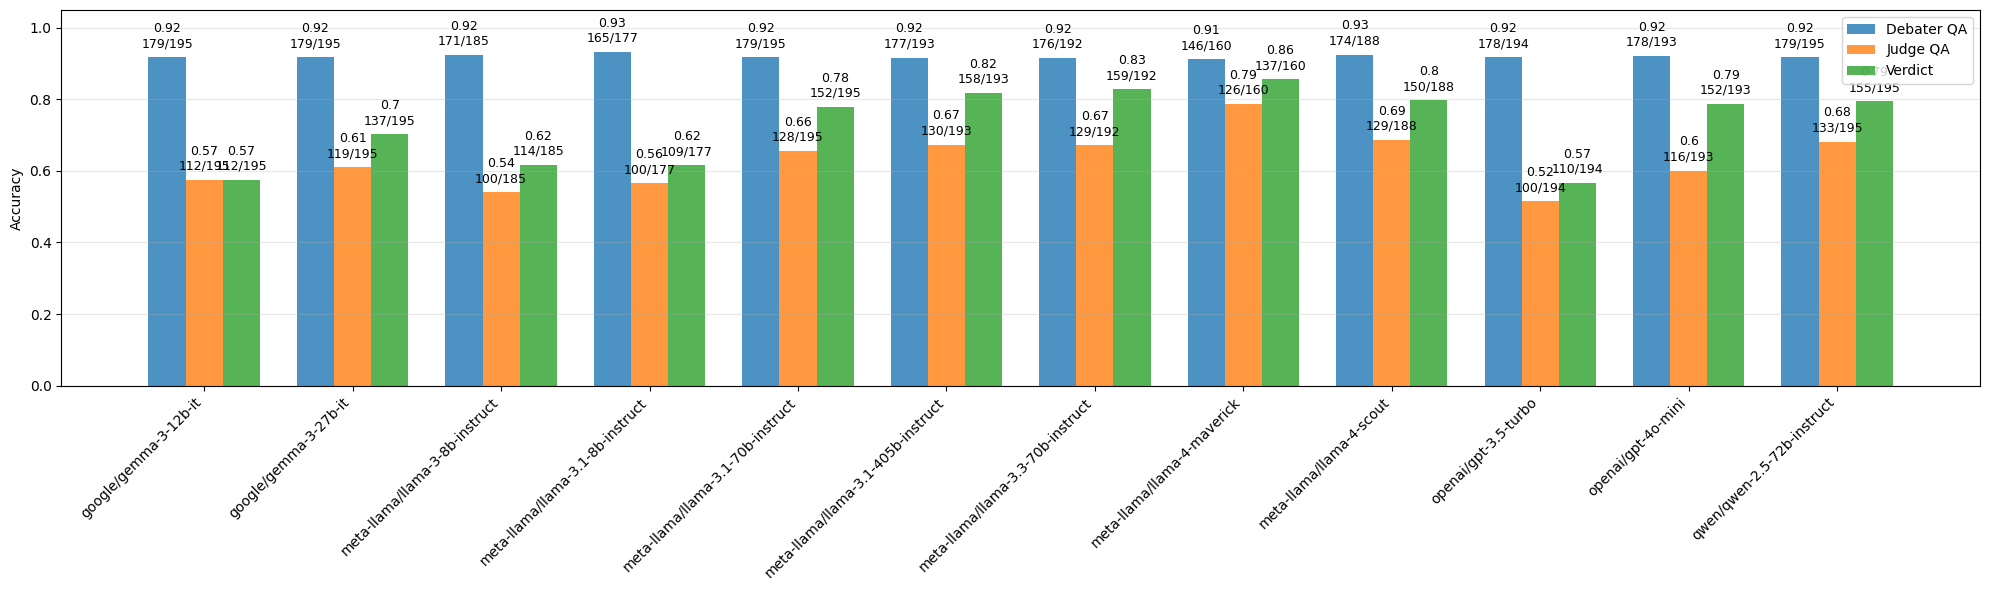

In [319]:
from plot_utils import *
aggregate_acc = aggregate_acc[aggregate_acc['name'] != 'x-ai/grok-4-fast']
print(aggregate_acc.shape)
plot_results_by_name(aggregate_acc, plot_gap_and_gain=False)
plt.show()


In [320]:
temp_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

aggregate_acc = aggregate_by_fields(temp_df, fields=['verdict_run_id_verdicts'])
aggregate_acc

,debater_qa_acc,judge_qa_acc,verdict_acc,debater_qa_n_correct,judge_qa_n_correct,verdict_n_correct,n_total,n_verdict_not_null,n_judge_qa_not_null,n_debater_qa_not_null,verdict_chose_idx_0,pgr,gap,gain,name
0,0.932203,0.564972,0.615819,165,100,109,177,177,177,177,0.525424,0.138462,0.367232,0.050847,02thlhv
1,0.922280,0.601036,0.787565,178,116,152,193,193,193,193,0.481865,0.580645,0.321244,0.186528,0sy00io
2,0.917949,0.656410,0.779487,179,128,152,195,195,195,195,0.497436,0.470588,0.261538,0.123077,1qqqkb6
3,0.917949,0.610256,0.702564,179,119,137,195,195,195,195,0.379487,0.300000,0.307692,0.092308,989j6y9
4,0.917949,0.574359,0.574359,179,112,112,195,195,195,195,0.282051,0.000000,0.343590,0.000000,9mg1flz
5,0.916667,0.671875,0.828125,176,129,159,192,192,192,192,0.494792,0.638298,0.244792,0.156250,9o07u2j
6,0.924324,0.540541,0.616216,171,100,114,185,185,185,185,0.464865,0.197183,0.383784,0.075676,hasqwjp
7,0.917526,0.515464,0.567010,178,100,110,194,194,194,194,0.649485,0.128205,0.402062,0.051546,ktjb8hq
8,0.917949,0.682051,0.794872,179,133,155,195,195,195,195,0.605128,0.478261,0.235897,0.112821,rhjasm2
9,0.925532,0.686170,0.797872,174,129,150,188,188,188,188,0.579787,0.466667,0.239362,0.111702,s8b6izi


In [321]:
aggregate_acc['gain'].mean(), aggregate_acc['gain'].median()

(np.float64(0.09788191654472123), np.float64(0.10200490998363332))

In [322]:
aggregate_acc['gain'].sort_values(ascending=False)

1     0.186528
5     0.156250
10    0.145078
2     0.123077
8     0.112821
9     0.111702
3     0.092308
6     0.075676
11    0.068750
7     0.051546
0     0.050847
4     0.000000
Name: gain, dtype: float64

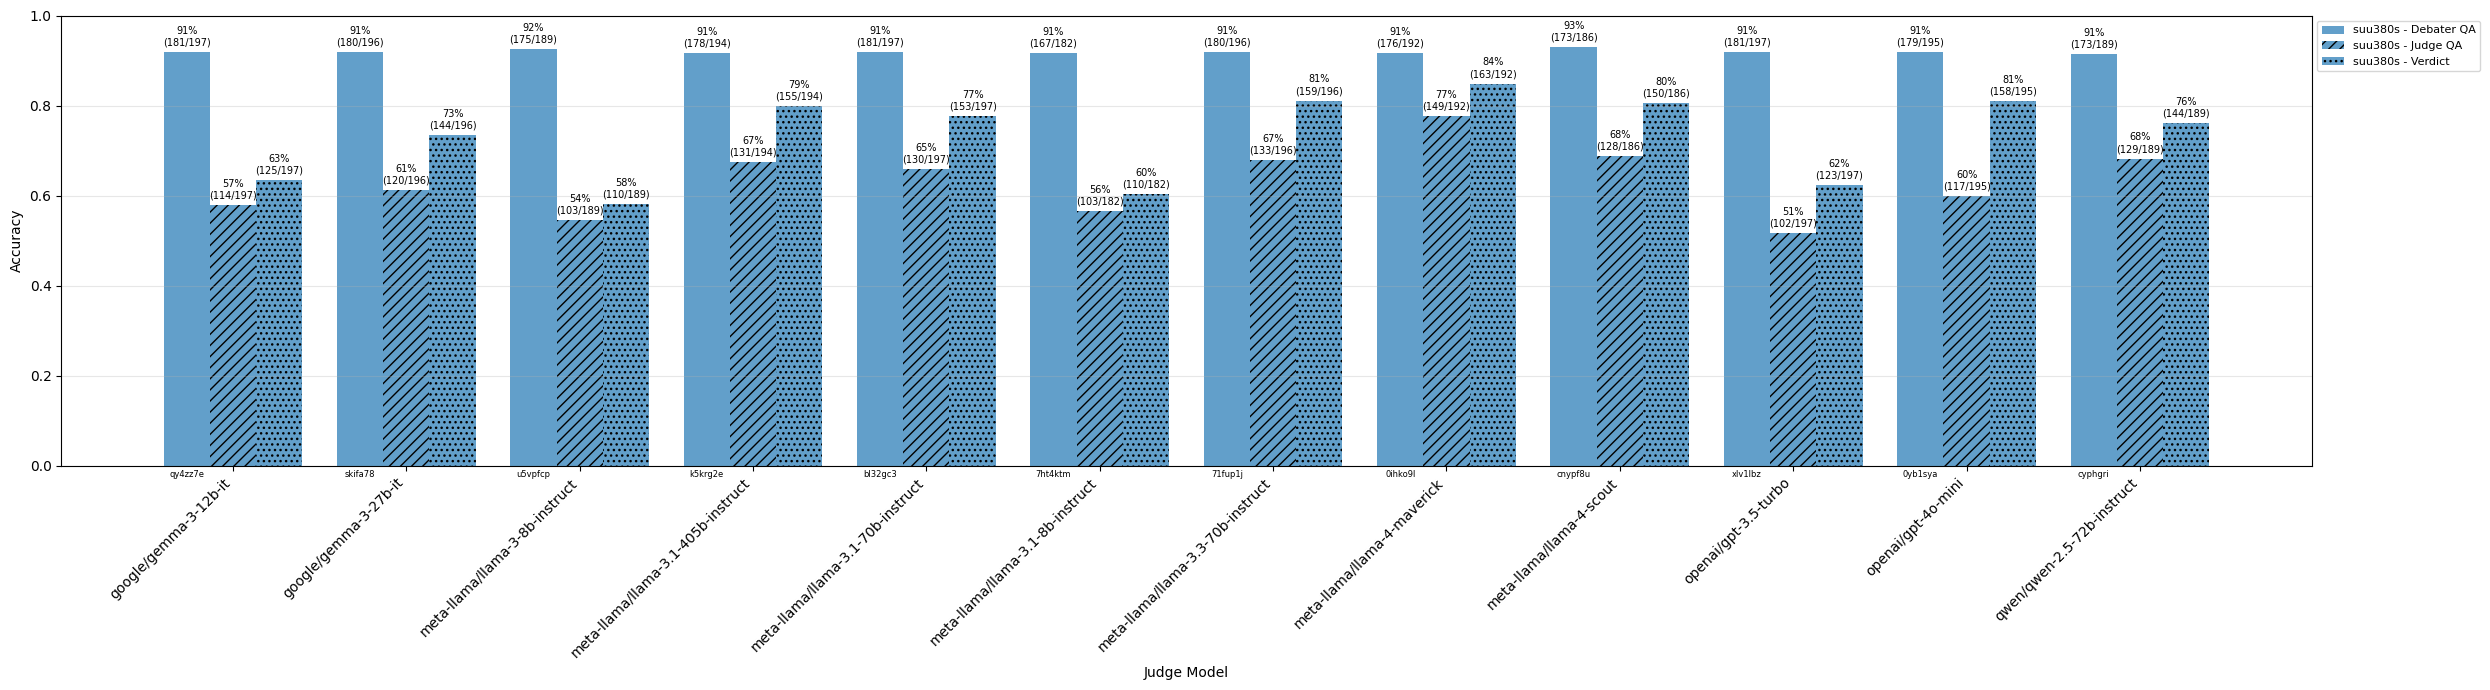

In [185]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

debate_run_id_labels = {
    'egkyot4': 'Gemini-3-pro Full scaffold',
    'ts9ga4y': 'Grok-4-fast Full scaffold',
    'txd06z5': 'Grok-4-fast Minimal scaffold',
    'wcsck4w': 'gpt-4o-mini Full scaffold',
    'yn1vu8h': 'gpt-4o-mini Minimal scaffold'
}

run_mapping = pd.DataFrame(data['runs'])
merged = aggregate_acc.merge(run_mapping, left_on='name', right_on='verdict_run_id')

metrics = ['debater_qa_acc', 'judge_qa_acc', 'verdict_acc']
metric_labels = ['Debater QA', 'Judge QA', 'Verdict']

for run_idx in [0]:
    plot_data = merged[merged['run_idx'] == run_idx].copy()
    
    judge_models = sorted(plot_data['model'].unique())
    debate_run_ids = sorted(plot_data['debate_run_id'].unique())
    
    n_judges = len(judge_models)
    n_debates = len(debate_run_ids)
    n_metrics = len(metrics)
    
    x = np.arange(n_judges)
    group_width = 0.8
    width = group_width / (n_debates * n_metrics)
    
    fig, ax = plt.subplots(figsize=(25, 7))
    
    colors = plt.cm.tab10(np.linspace(0, 1, n_debates))
    hatches = ['', '///', '...']
    # hatches = ['', '', '']

    
    metric_x_y_map = {
        'debater_qa_acc': ('debater_qa_n_correct', 'n_debater_qa_not_null'),
        'judge_qa_acc': ('judge_qa_n_correct', 'n_judge_qa_not_null'),
        'verdict_acc': ('verdict_n_correct', 'n_verdict_not_null')
    }
    
    for i, debate_run_id in enumerate(debate_run_ids):
        for j, (metric, metric_label) in enumerate(zip(metrics, metric_labels)):
            values = []
            verdict_run_ids = []
            x_values = []
            y_values = []
            for judge_model in judge_models:
                row = plot_data[(plot_data['model'] == judge_model) & 
                               (plot_data['debate_run_id'] == debate_run_id)]
                if len(row) > 0:
                    values.append(row[metric].values[0])
                    verdict_run_ids.append(row['verdict_run_id'].values[0])
                    x_field, y_field = metric_x_y_map[metric]
                    x_values.append(int(row[x_field].values[0]))
                    y_values.append(int(row[y_field].values[0]))
                else:
                    values.append(0)
                    verdict_run_ids.append('')
                    x_values.append(0)
                    y_values.append(0)
            
            offset = (i - n_debates / 2 + 0.5) * (group_width / n_debates) + (j - n_metrics / 2 + 0.5) * width
            label = f"{debate_run_id_labels.get(debate_run_id, debate_run_id)} - {metric_label}" if j == 0 else ""
            bars = ax.bar(x + offset, values, width, label=label, color=colors[i], alpha=0.7, hatch=hatches[j])
            
            for k, (bar, verdict_run_id, x_val, y_val) in enumerate(zip(bars, verdict_run_ids, x_values, y_values)):
                if verdict_run_id and j == 0:
                    ax.text(bar.get_x() + bar.get_width() / 2, -0.01, verdict_run_id,
                           ha='center', va='top', fontsize=6)
                if x_val > 0 or y_val > 0:
                    pct = int(x_val / y_val * 100) if y_val > 0 else 0
                    label_text = f"{pct}%\n({x_val}/{y_val})"
                    # label_text =  f"{pct}% ({y_val})"
                    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, label_text,
                           ha='center', va='bottom', fontsize=7, color='black')
    
    ax.set_xlabel('Judge Model')
    ax.set_ylabel('Accuracy')
    # ax.set_title(f'Accuracy Metrics by Judge Model and Debate Run ID (Repetition {run_idx})')
    ax.set_xticks(x)
    ax.set_xticklabels(judge_models, rotation=45, ha='right')
    
    from matplotlib.patches import Patch
    legend_elements = []
    for i, debate_run_id in enumerate(debate_run_ids):
        for j, metric_label in enumerate(metric_labels):
            label = f"{debate_run_id_labels.get(debate_run_id, debate_run_id)} - {metric_label}"
            legend_elements.append(Patch(facecolor=colors[i], alpha=0.7, hatch=hatches[j], label=label))
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
    
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()


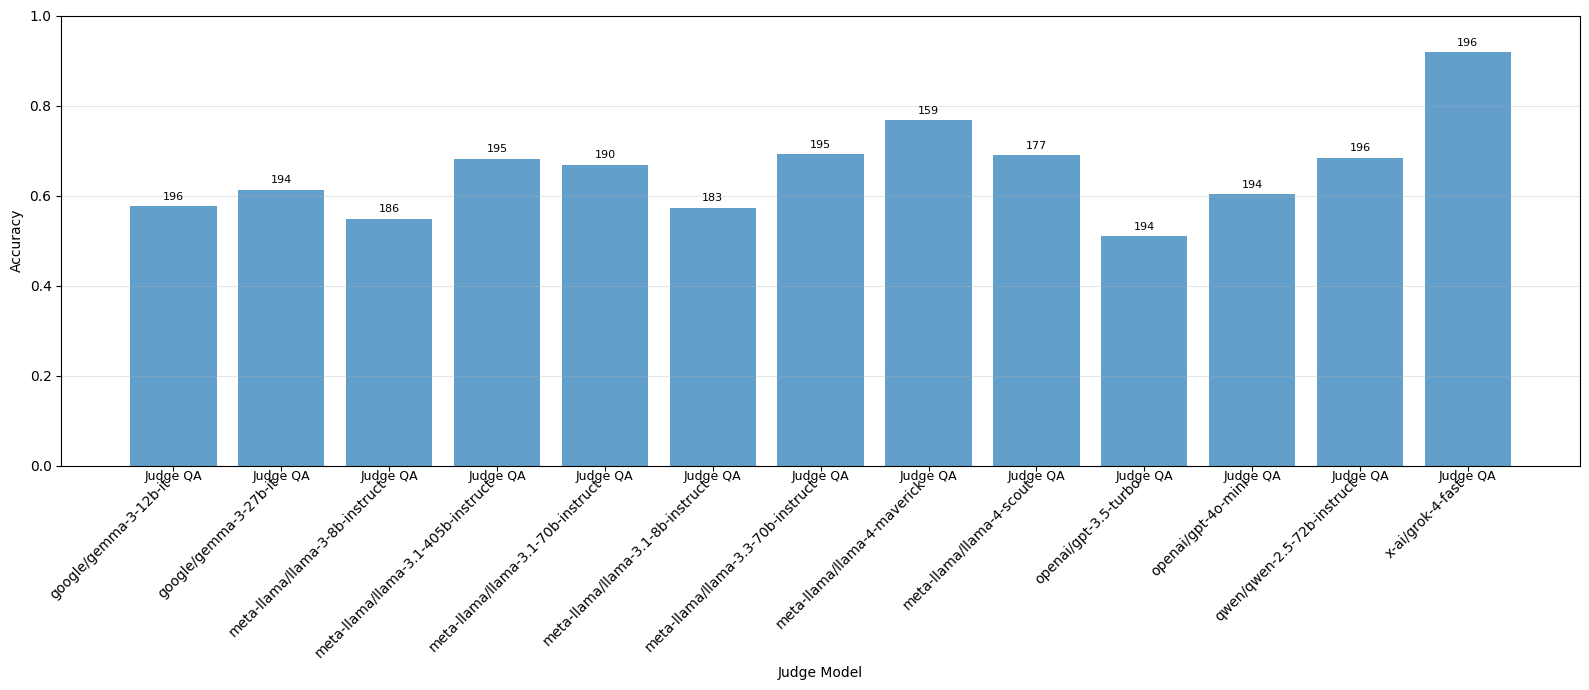

In [122]:
for run_idx in [0]:
    run_mapping = pd.DataFrame(data['runs'])
    merged = aggregate_acc.merge(run_mapping, left_on='name', right_on='verdict_run_id')

    plot_data = merged[merged['run_idx'] == run_idx].copy()
    
    judge_models = sorted(plot_data['model'].unique())
    
    if 'upto_turns' in plot_data.columns:
        # upto_turns_list = sorted([x for x in plot_data['upto_turns'].dropna().unique() if x != 0])
        upto_turns_list= sorted([x for x in plot_data['upto_turns'].dropna().unique()])
        
    else:
        upto_turns_list = [None]
    
    n_judges = len(judge_models)
    n_turns = len(upto_turns_list)
    
    x = np.arange(n_judges)
    group_width = 0.8
    width = group_width / (1 + n_turns)
    
    bar_color = plt.cm.tab10(0)
    chose_idx_0_color = plt.cm.tab10(1)
    hatches = ['', '///']
    
    fig, ax = plt.subplots(figsize=(16, 7))
    
    judge_qa_values = []
    judge_qa_counts = []
    for judge_model in judge_models:
        rows = plot_data[plot_data['model'] == judge_model]
        if len(rows) > 0:
            avg_value = rows['judge_qa_acc'].mean()
            judge_qa_values.append(avg_value)
            n_correct = int(rows['judge_qa_n_correct'].sum())
            n_total = int(rows['n_judge_qa_not_null'].sum())
            judge_qa_counts.append((n_correct, n_total))
        else:
            judge_qa_values.append(0)
            judge_qa_counts.append((0, 0))
    
    judge_qa_offset = -group_width / 2 + width / 2
    bars_judge_qa = ax.bar(x + judge_qa_offset, judge_qa_values, width, label='Judge QA', color=bar_color, alpha=0.7, hatch=hatches[0])
    
    for bar, value, (n_correct, n_total) in zip(bars_judge_qa, judge_qa_values, judge_qa_counts):
        ax.text(bar.get_x() + bar.get_width() / 2, -0.01, 'Judge QA',
               ha='center', va='top', fontsize=9)
        if n_total > 0:
            pct = int(value * 100)
            # ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{pct}% ({n_correct}/{n_total})',
                #    ha='center', va='bottom', fontsize=8)
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{n_total}',
                   ha='center', va='bottom', fontsize=8)
    
    for i, upto_turns in enumerate(upto_turns_list):
        if upto_turns is not None:
            turn_data = plot_data[plot_data['upto_turns'] == upto_turns].copy()
        else:
            turn_data = plot_data.copy()
        
        verdict_values = []
        chose_idx_0_values = []
        verdict_counts = []
        for judge_model in judge_models:
            rows = turn_data[turn_data['model'] == judge_model]
            if len(rows) > 1:
                raise Exception('Check why rows greater than 1')
            verdict_values.append(rows.iloc[0]['verdict_acc'])
            chose_idx_0_values.append(rows.iloc[0]['verdict_chose_idx_0'])
            n_correct = int(rows.iloc[0]['verdict_n_correct'])
            n_total = int(rows.iloc[0]['n_verdict_not_null'])
            verdict_counts.append((n_correct, n_total))
            # if len(rows) > 0:
            #     print(len(rows))
            #     avg_value = rows['verdict_acc'].mean()
            #     verdict_values.append(avg_value)
            # else:
            #     verdict_values.append(0)

        
        offset = judge_qa_offset + width + i * width
        label = f"{upto_turns if upto_turns is not None else 'All'} Turns"
        bars = ax.bar(x + offset, verdict_values, width, label=label, color=bar_color, alpha=0.7, hatch=hatches[1])
        
        # bars_chose_idx_0 = ax.bar(x + offset, chose_idx_0_values, width, color=chose_idx_0_color, alpha=0.4)
        
        for k, (bar, value, (n_correct, n_total)) in enumerate(zip(bars, verdict_values, verdict_counts)):
            turn_label = f"{upto_turns if upto_turns is not None else 'All'}"
            ax.text(bar.get_x() + bar.get_width() / 2, -0.01, turn_label,
                   ha='center', va='top', fontsize=12)
            if n_total > 0:
                pct = int(value * 100)
                # ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{pct}% ({n_correct}/{n_total})',
                    #    ha='center', va='bottom', fontsize=8)
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{n_total}',
                    ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Judge Model')
    ax.set_ylabel('Accuracy')
    title = f'Judge QA and Verdict Accuracy by Turn Limit'
    if run_idx is not None:
        title += f' (Repetition {run_idx})'
    # ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(judge_models, rotation=45, ha='right')
    

    
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()


### By Category

In [ ]:
# dataset = load_dataset('Idavidrein/gpqa', 'gpqa_diamond')['train']
# dataset_df = dataset.to_pandas()
# dataset_df = dataset_df.rename({'Question': 'question', 'High-level domain': 'high_level_domain'}, axis=1)
# dataset_df['high_level_domain'] = dataset_df['high_level_domain'].str.lower()
# verdicts_df = verdicts_df.merge(dataset_df[['question', 'high_level_domain']], left_on=['question_verdicts'], right_on=['question'], how='left', suffixes=('', '_dataset'))

In [234]:
mmlu_dataset = load_dataset('TIGER-Lab/MMLU-Pro')['test']

category_map = {}
for idx in range(len(mmlu_dataset)):
    category_map[idx] = mmlu_dataset[idx].get('category', None)
verdicts_df['high_level_domain'] = verdicts_df['question_idx_debates'].map(category_map)

In [ ]:
# temp_df = verdicts_df.copy()

# chemistry_df = temp_df[temp_df['high_level_domain'] == 'chemistry']
# physics_df = temp_df[temp_df['high_level_domain'] == 'physics']

# chemistry_acc = aggregate_by_fields(chemistry_df, ['config_judge_model_verdicts'])
# physics_acc = aggregate_by_fields(physics_df, ['config_judge_model_verdicts'])

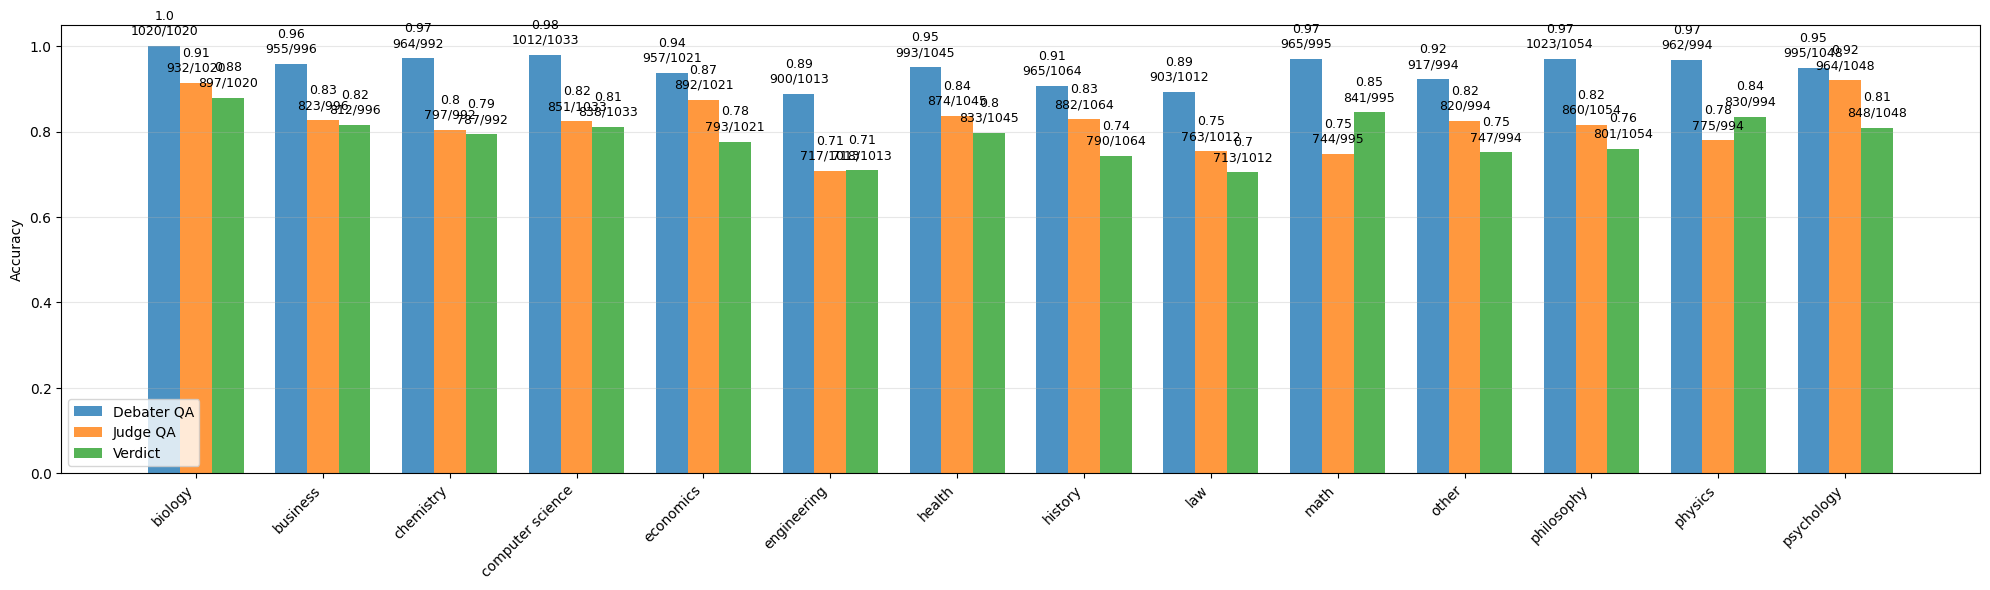

In [244]:
temp_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

aggregate_acc = aggregate_by_fields(temp_df, fields=['high_level_domain'])
aggregate_acc

from plot_utils import *
plot_results_by_name(aggregate_acc, field=None, plot_gap_and_gain=False)
plt.show()

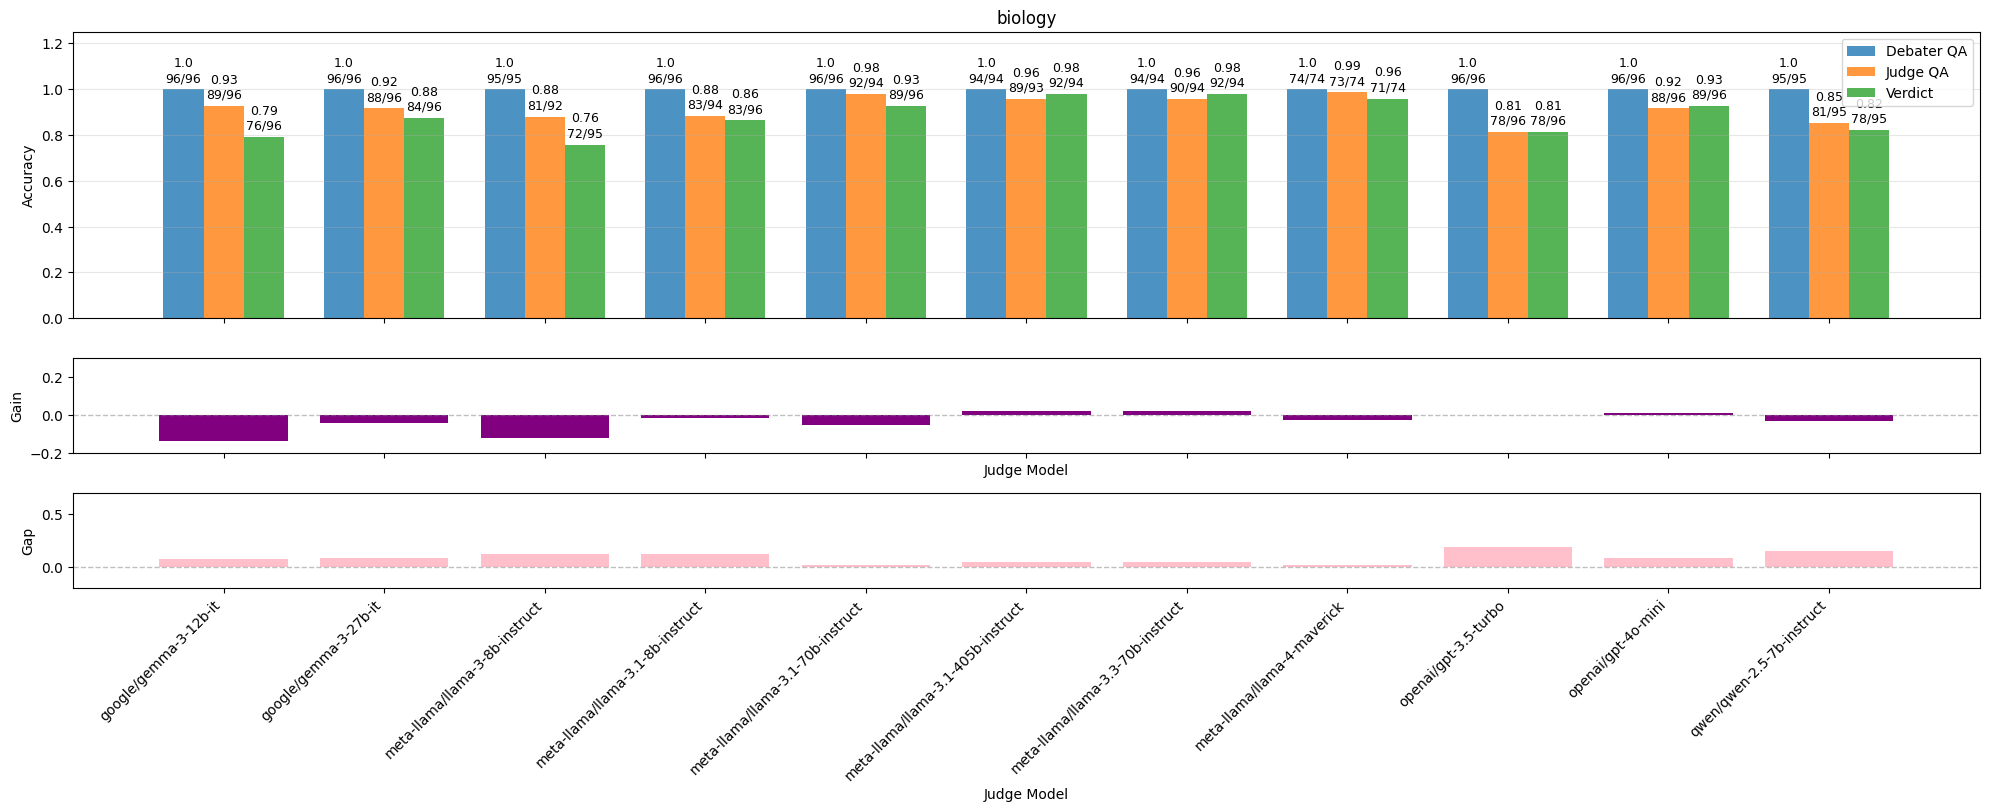

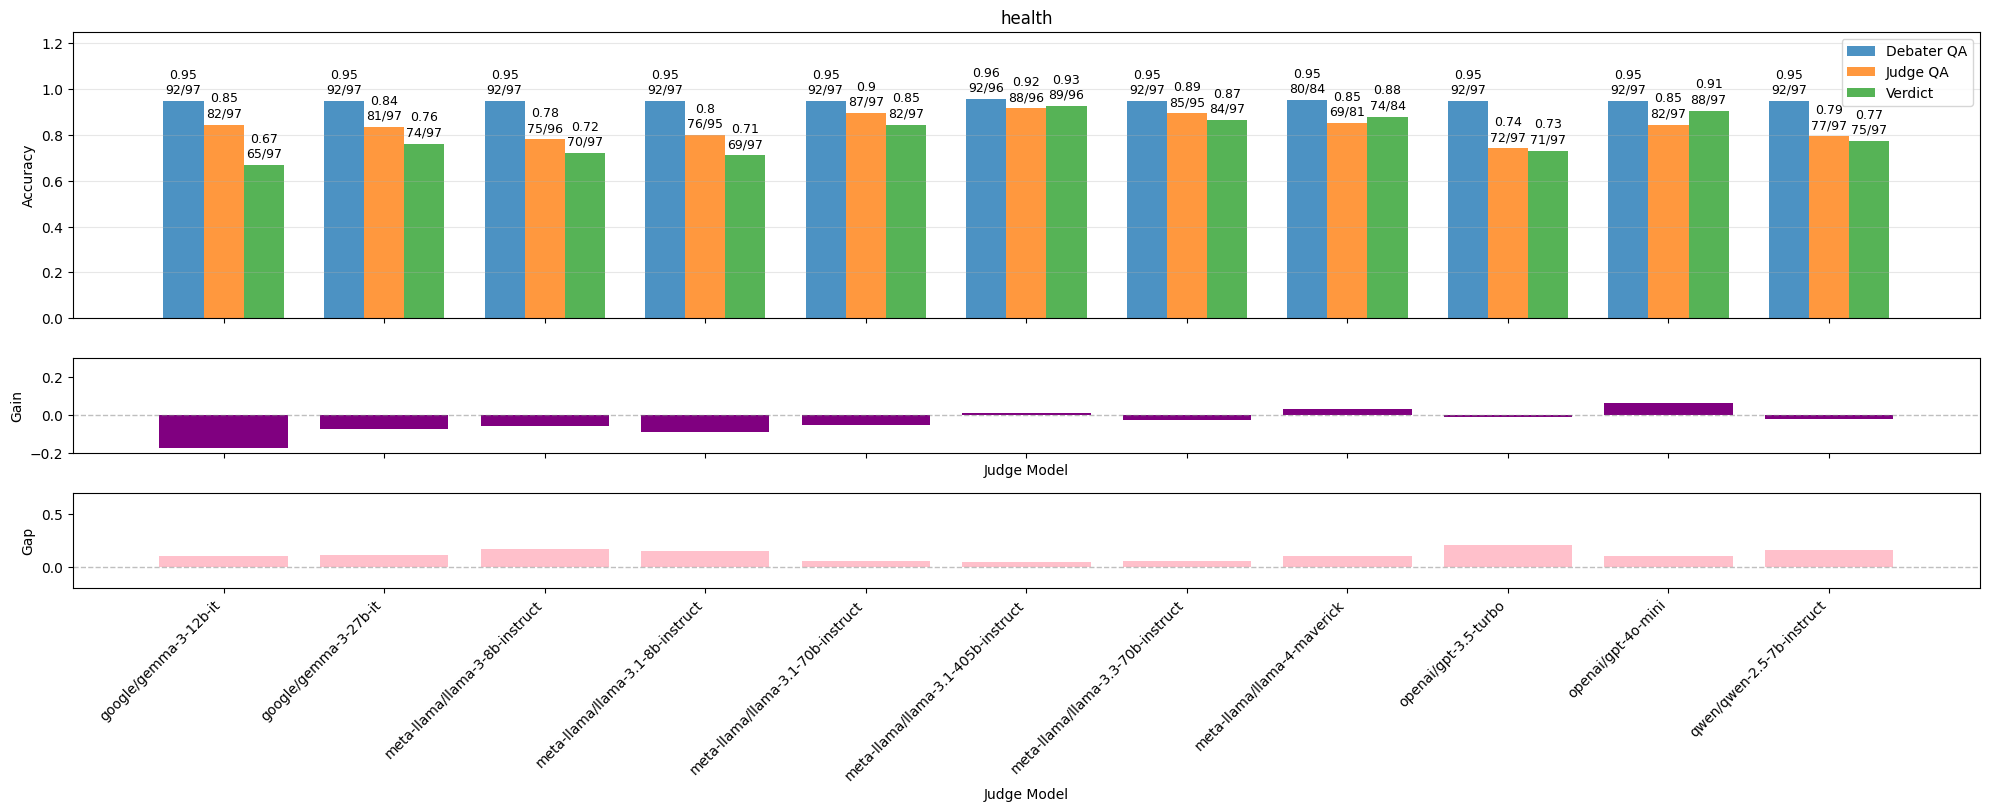

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:208: RuntimeWarning: divide by zero encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),


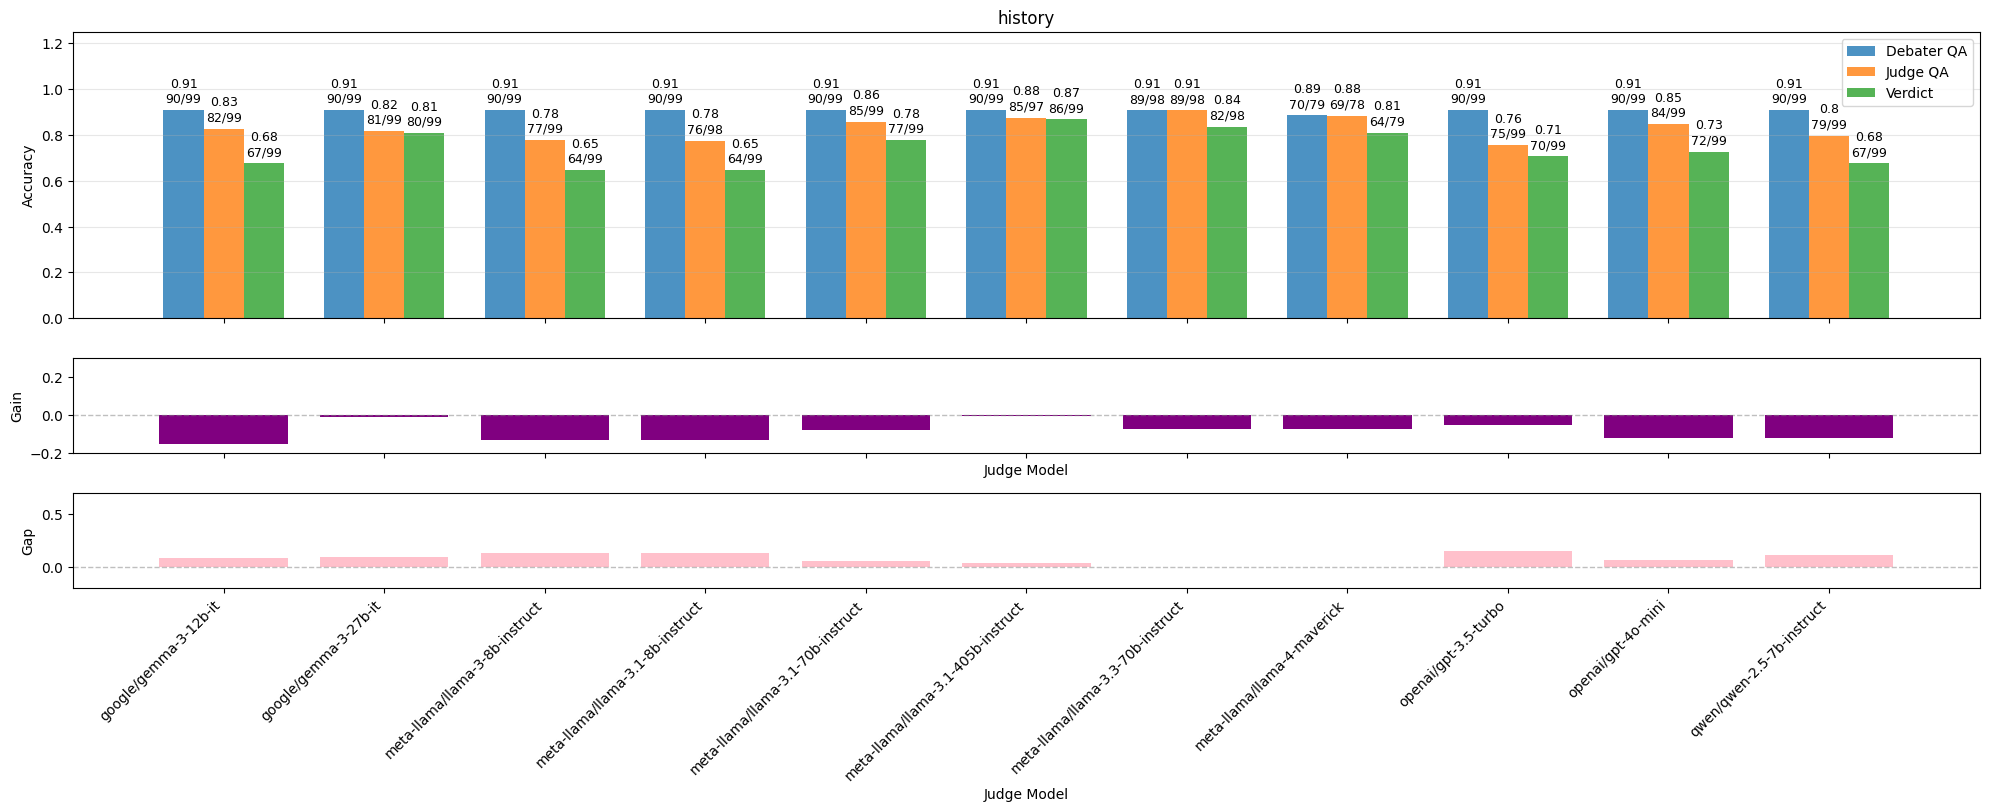

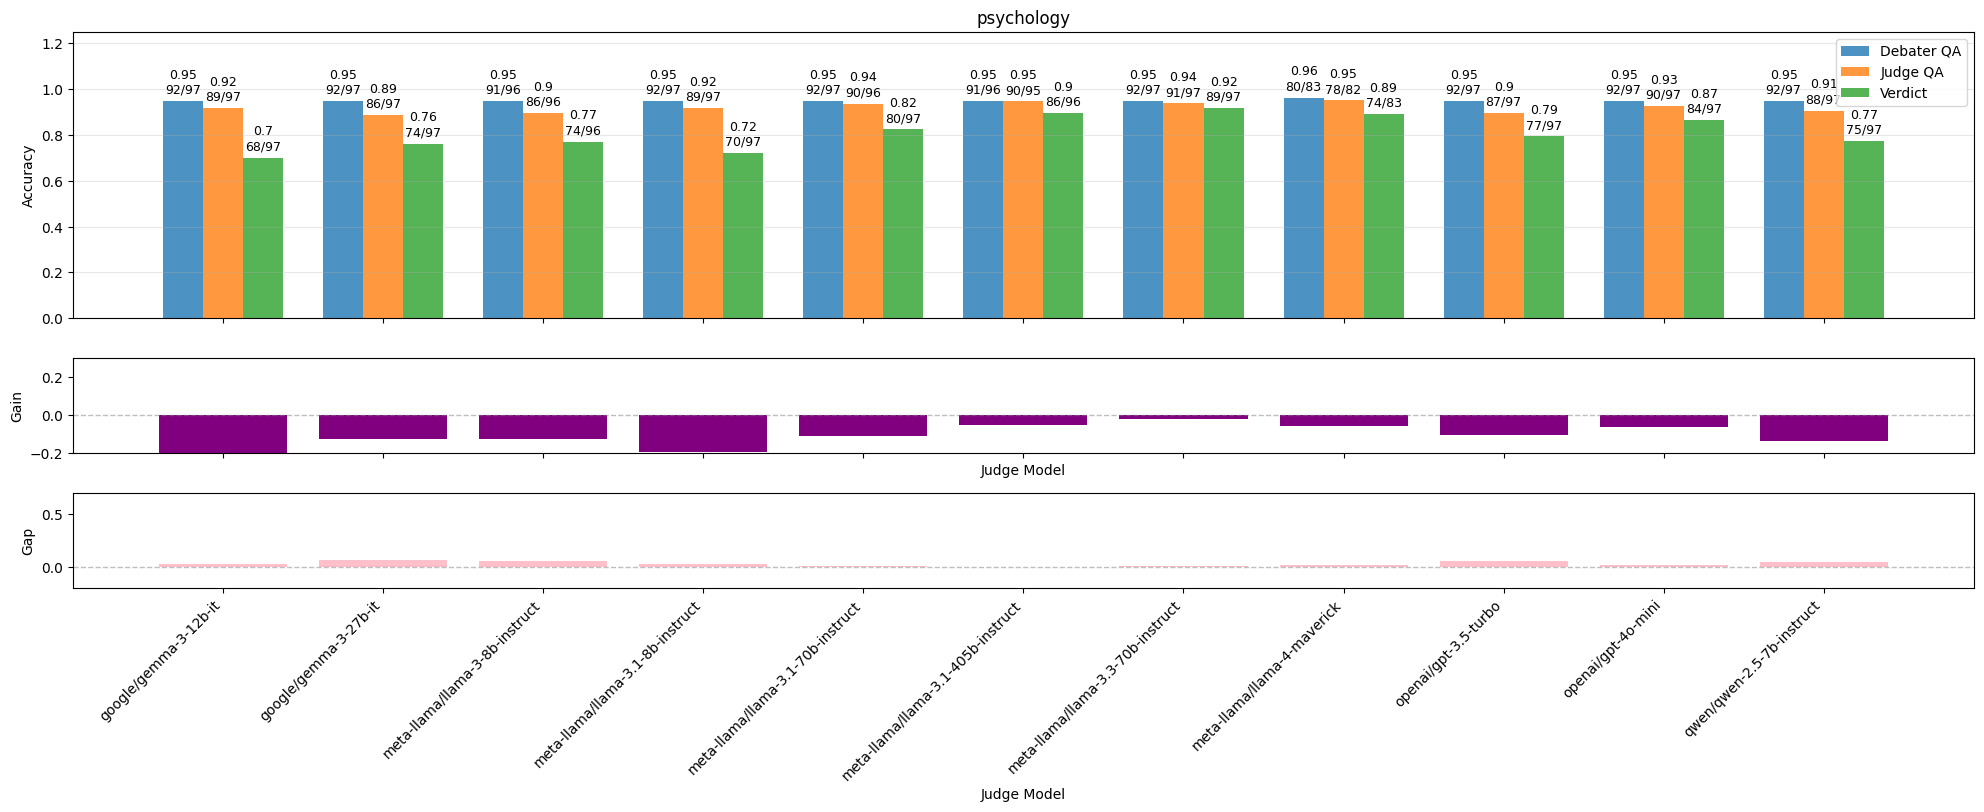

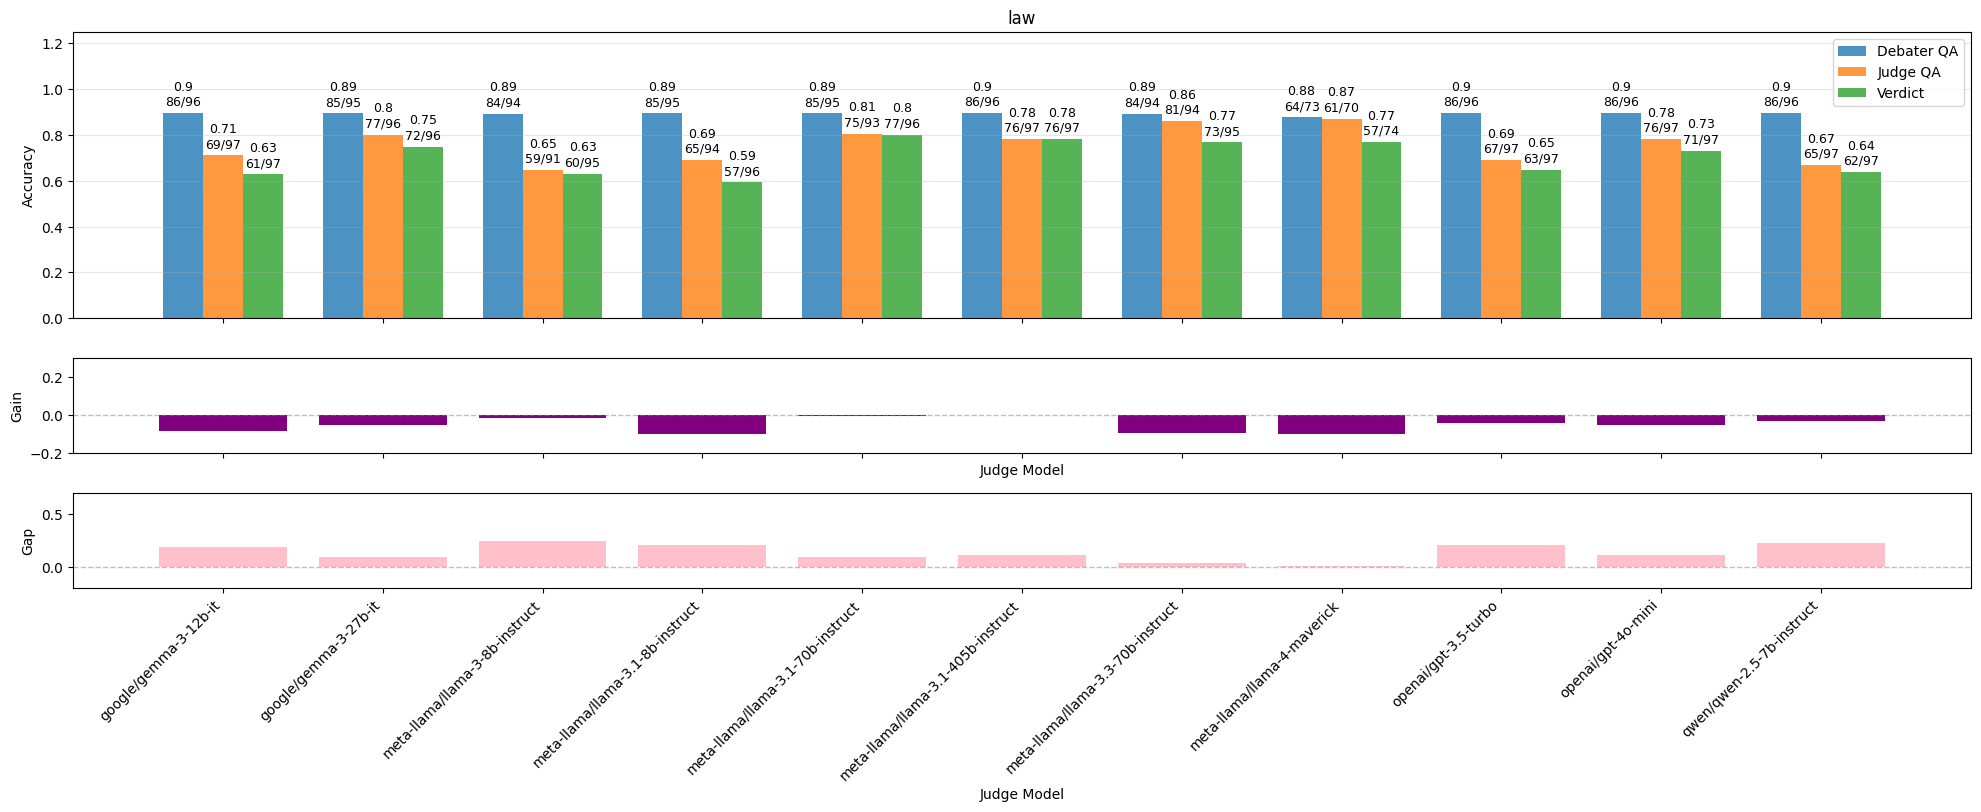

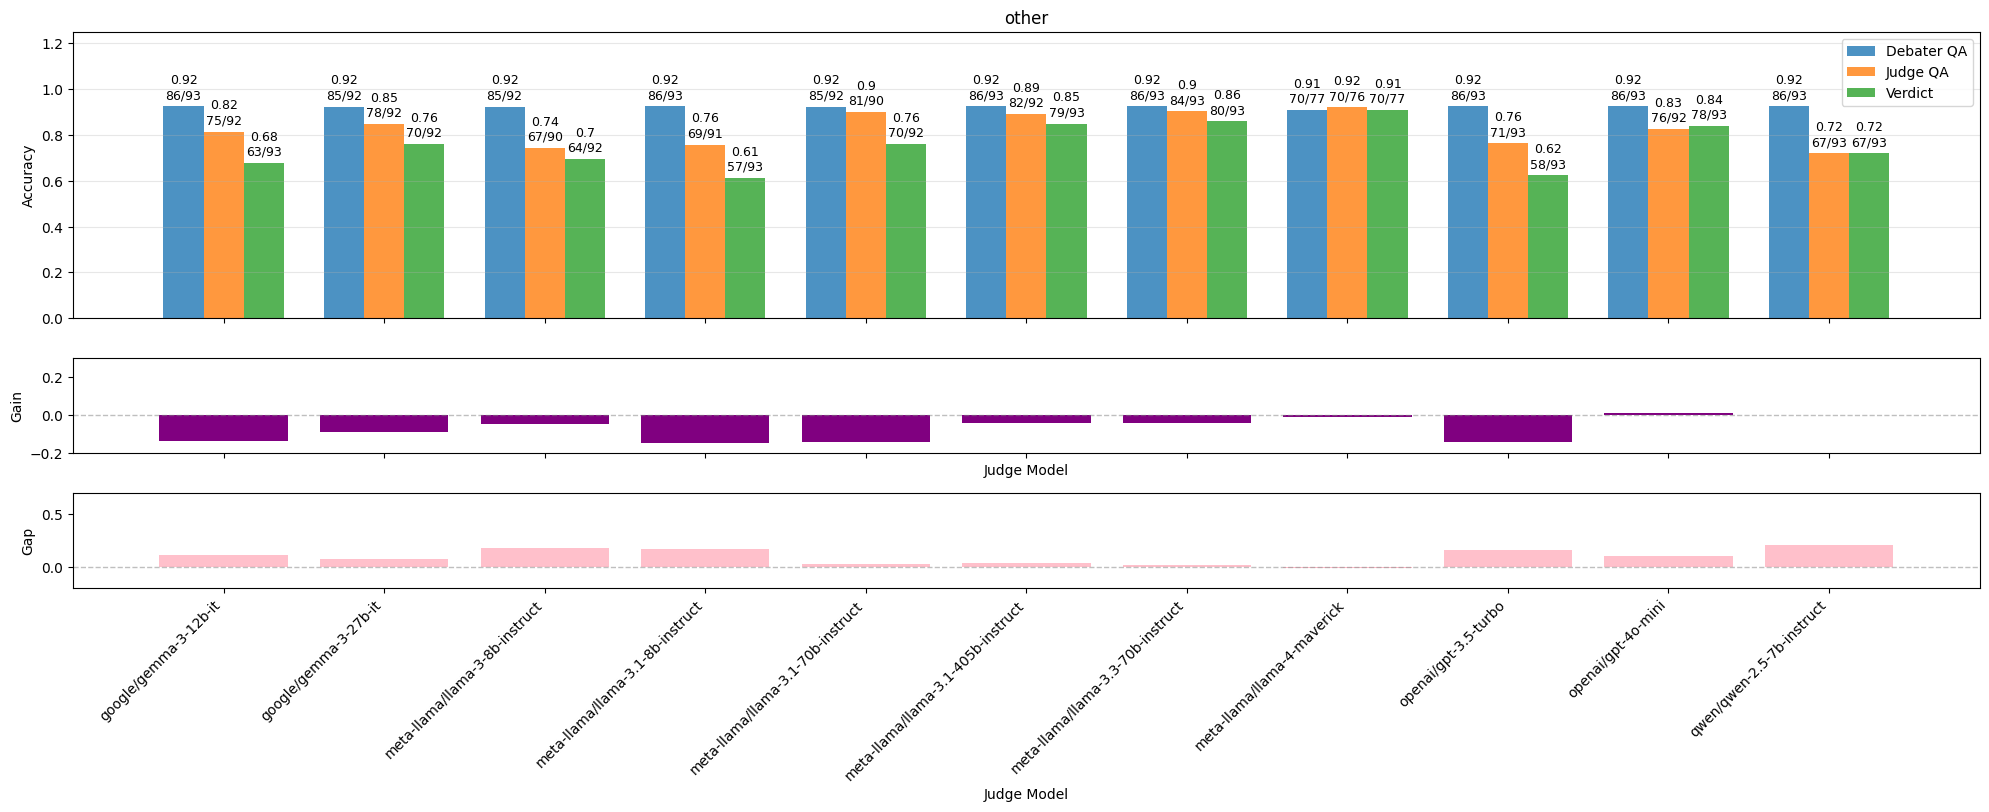

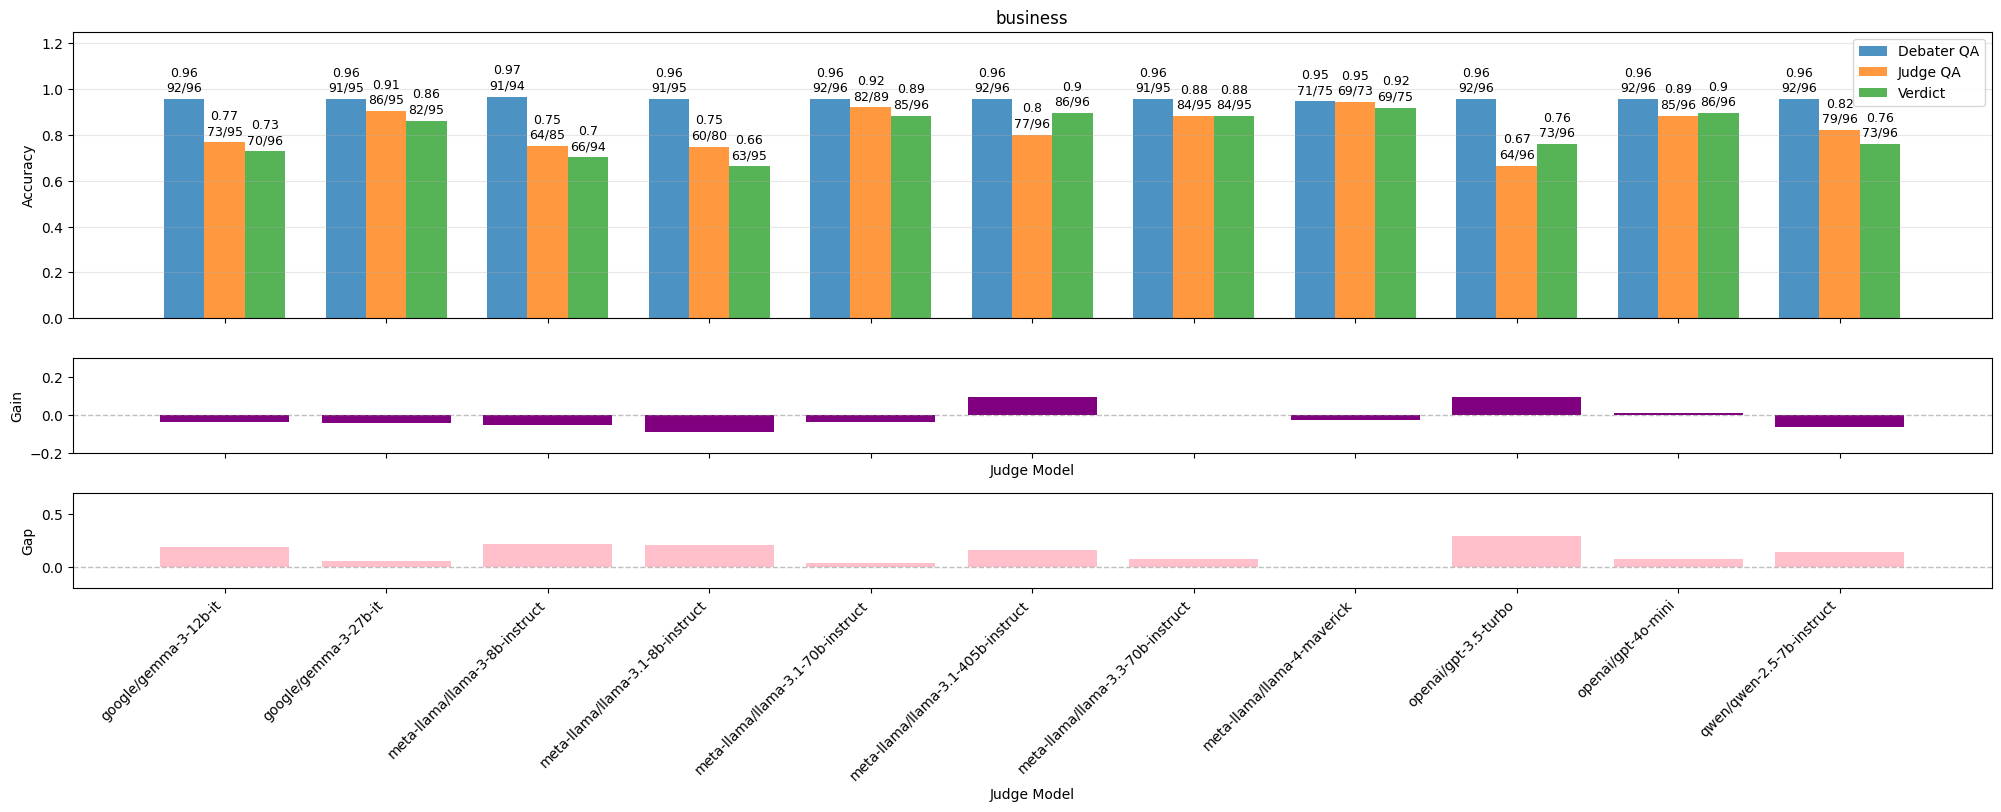

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:208: RuntimeWarning: divide by zero encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),


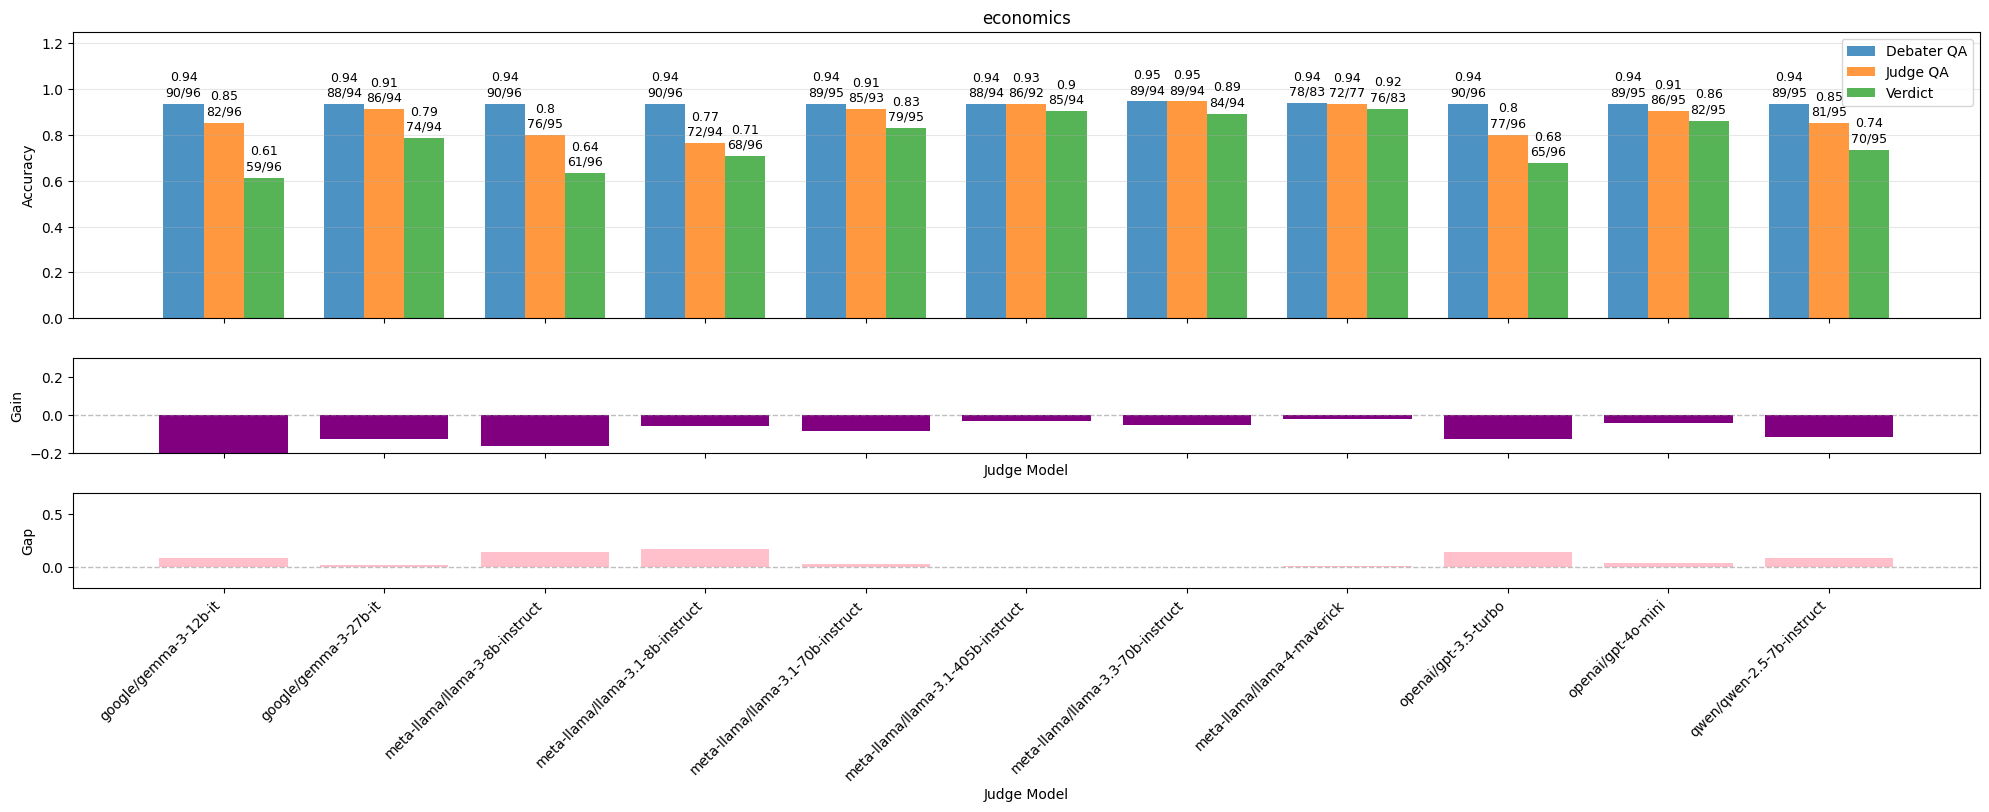

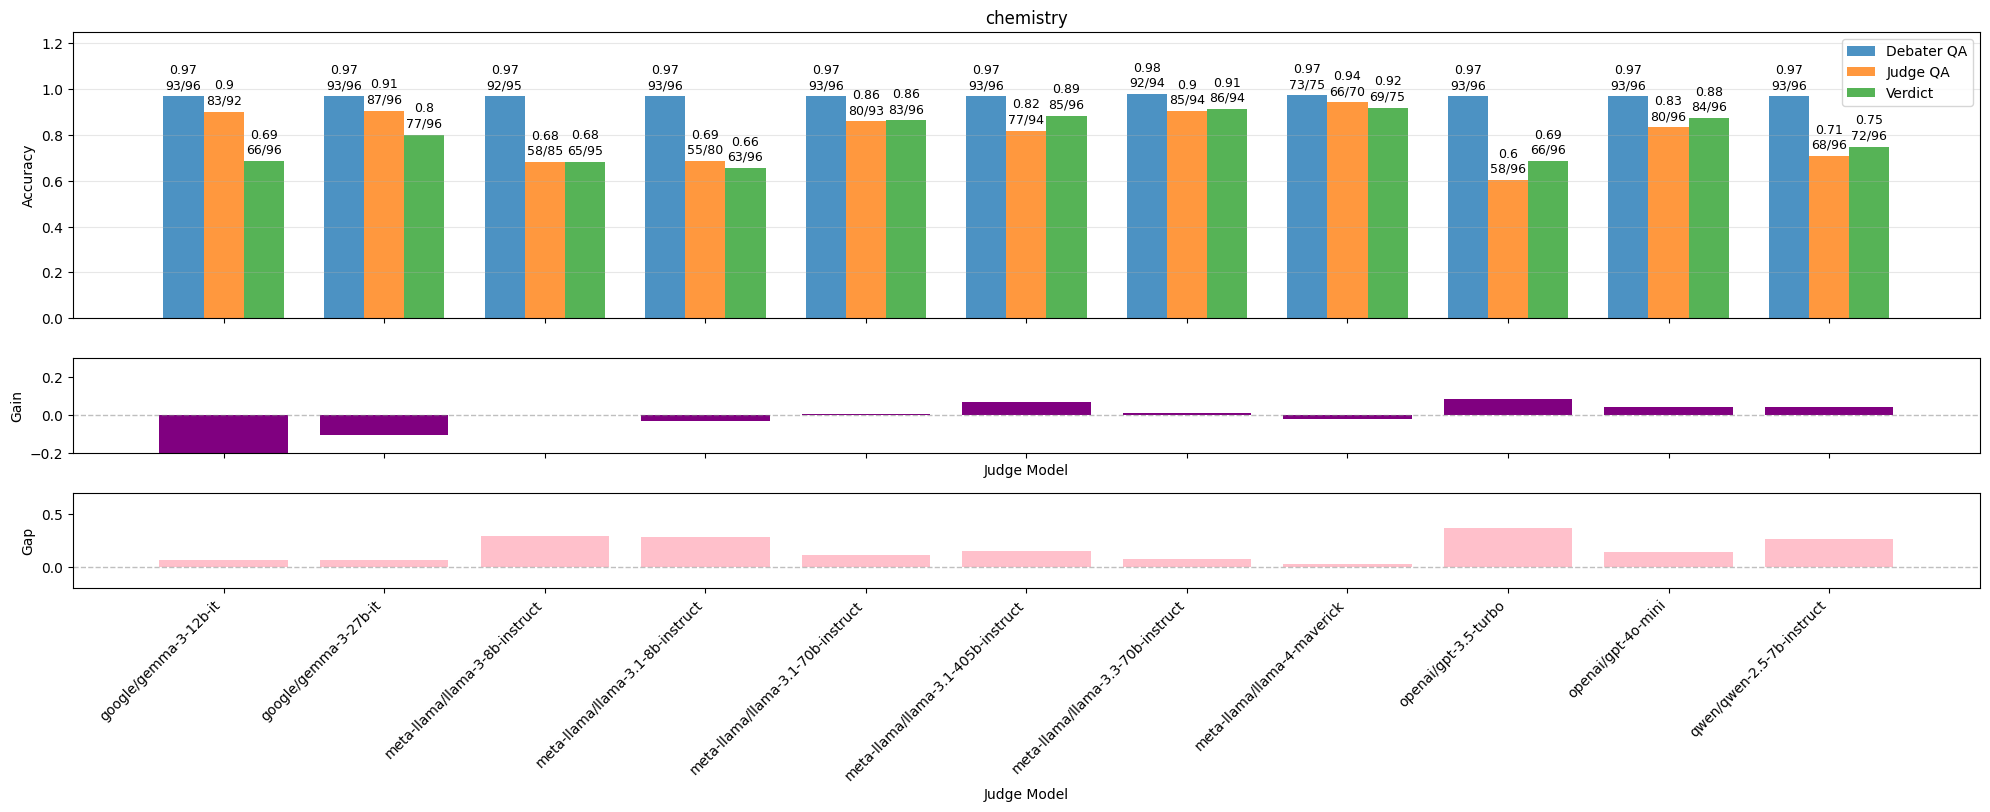

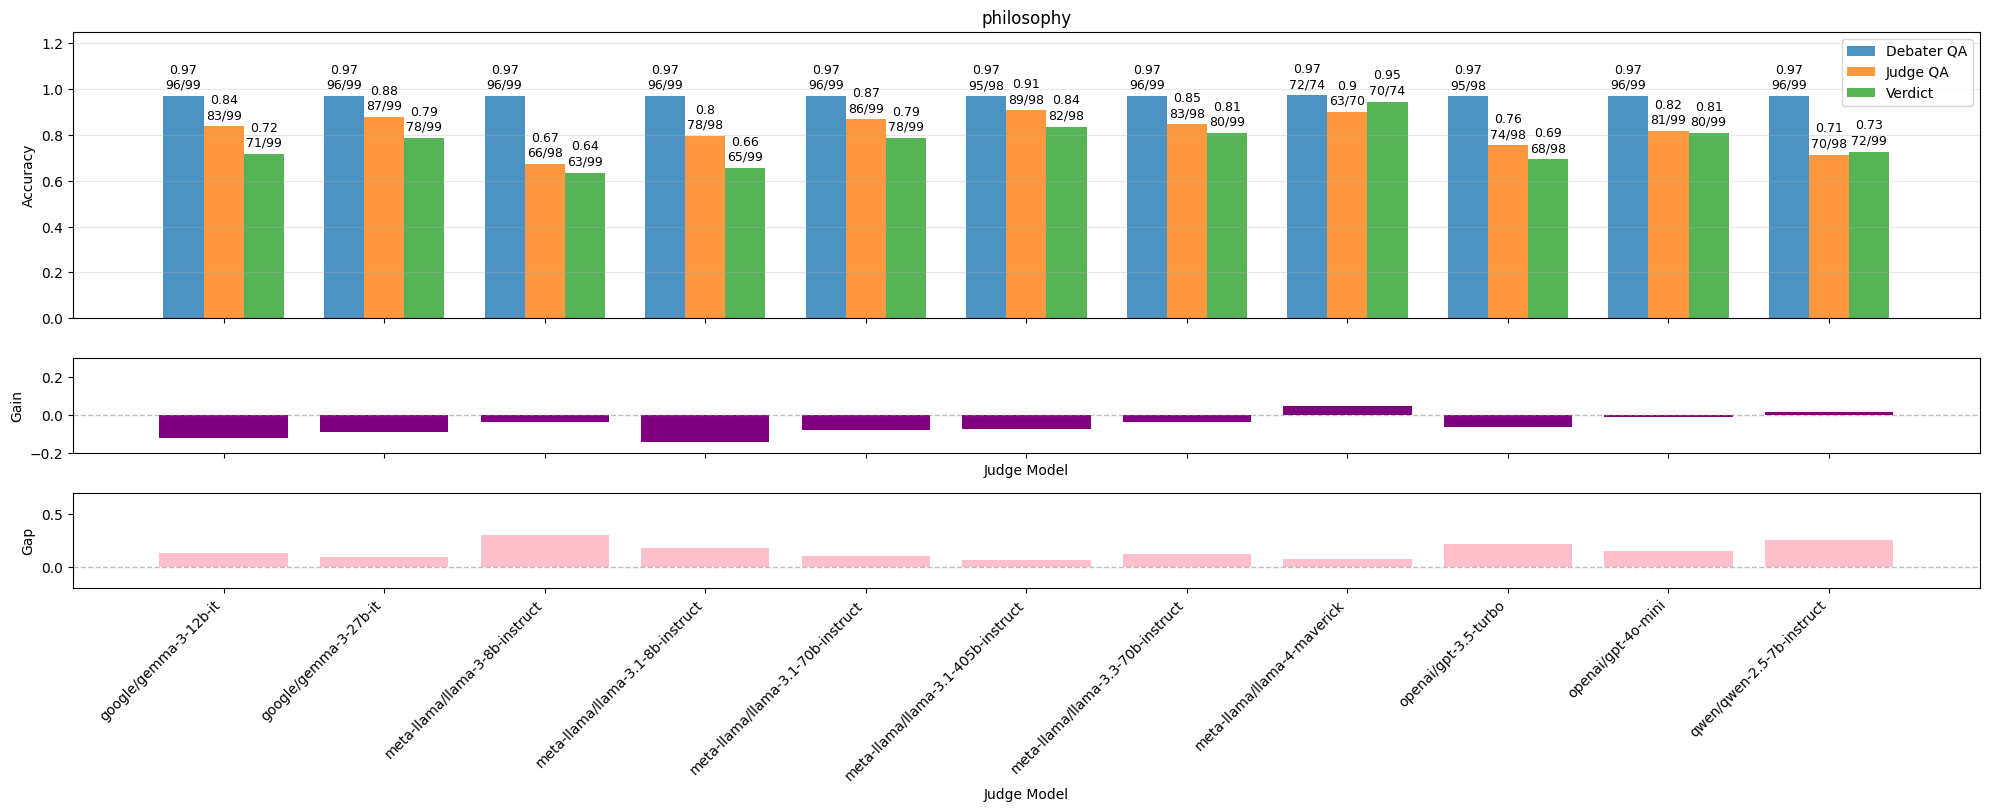

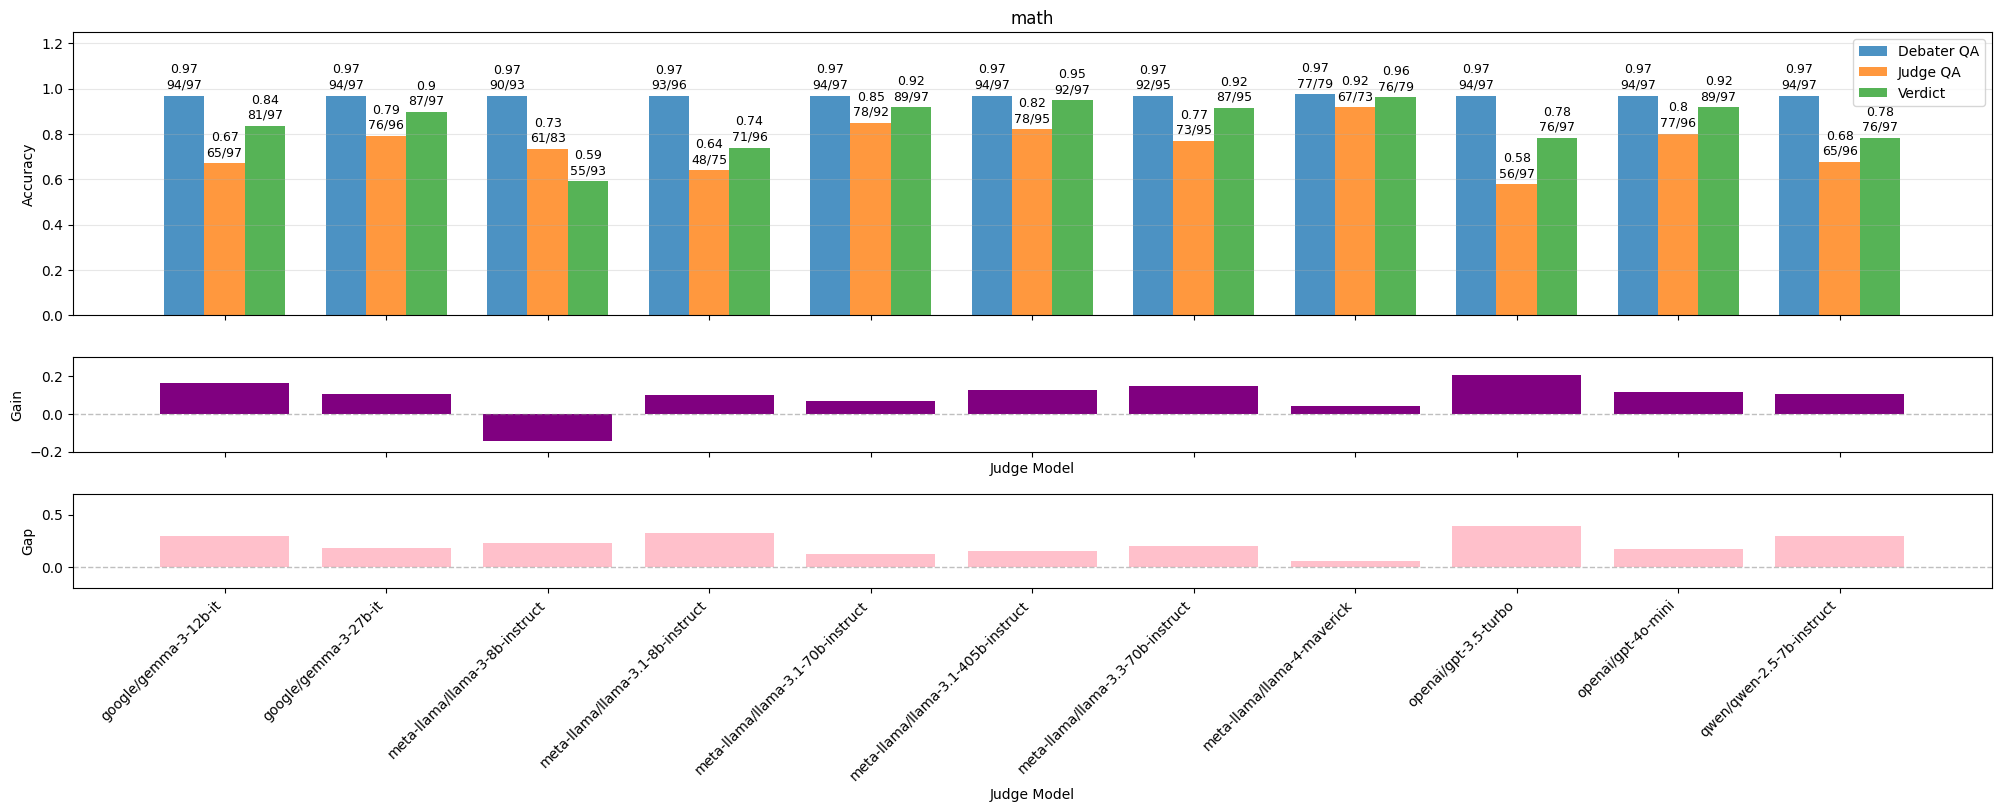

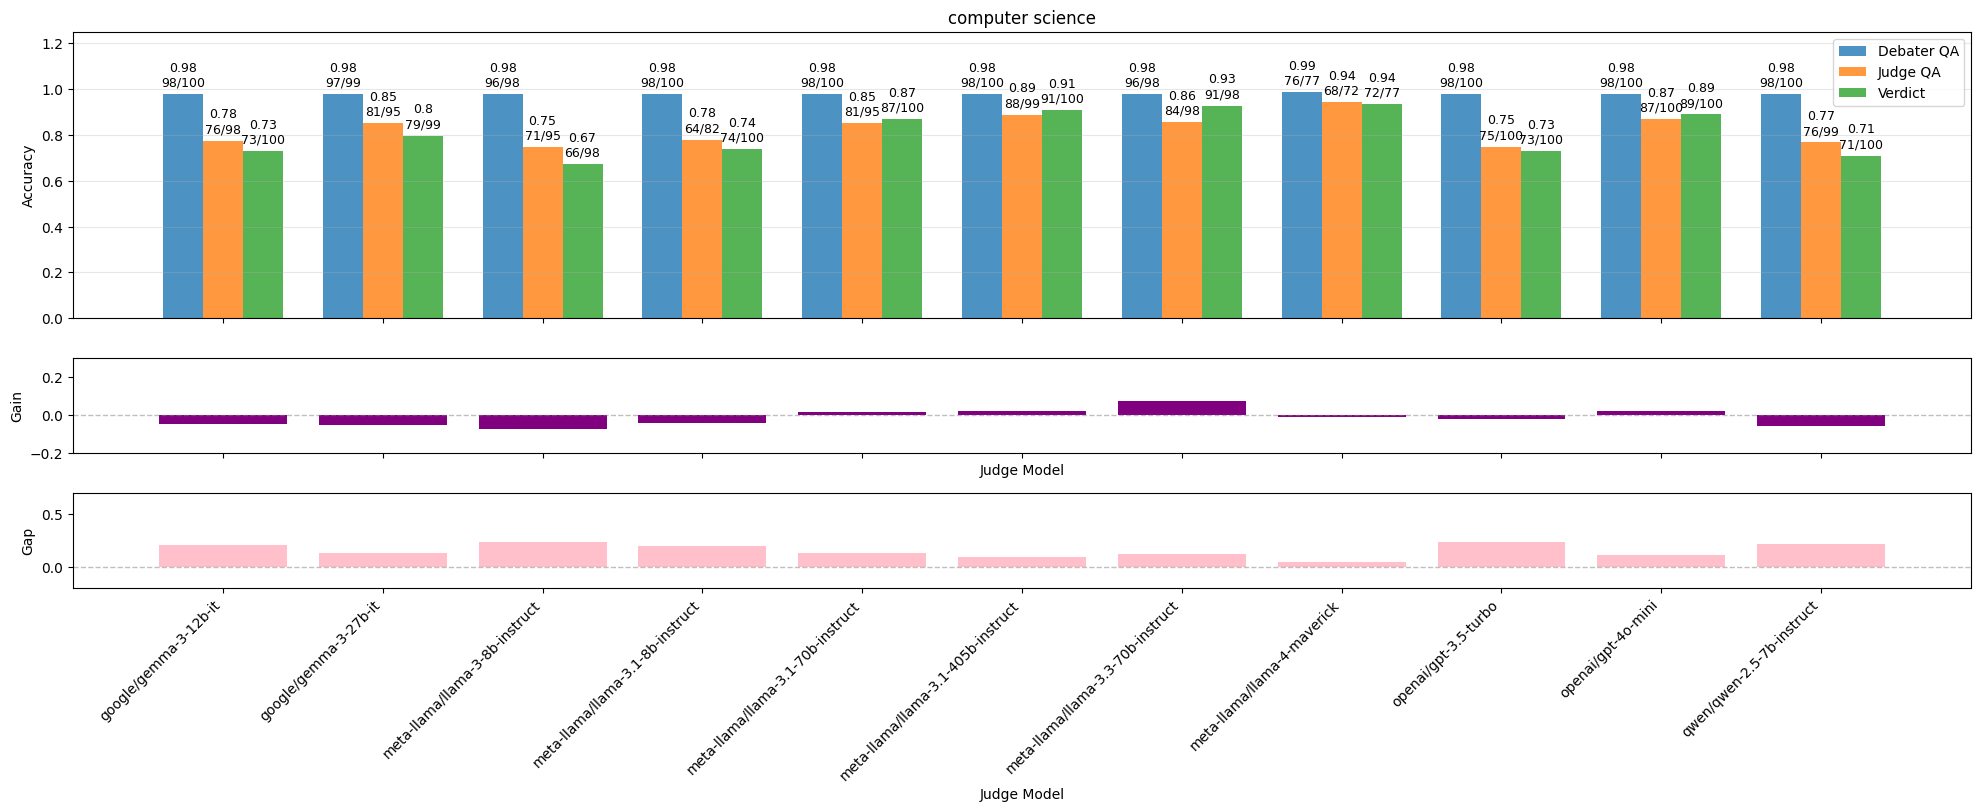

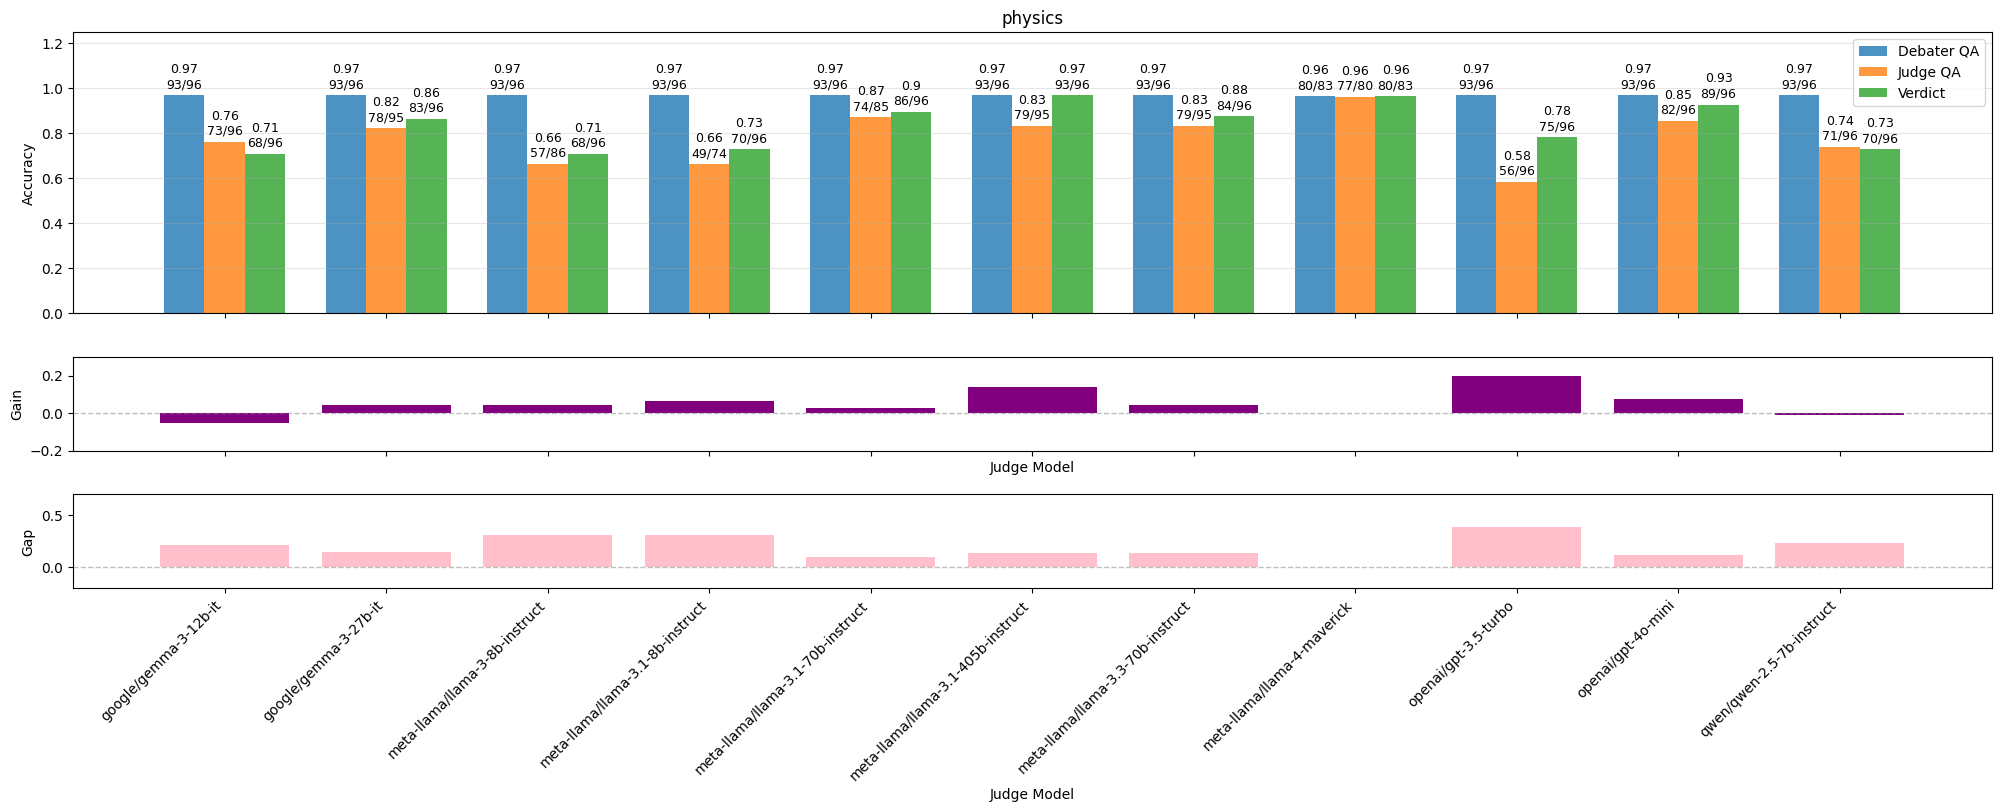

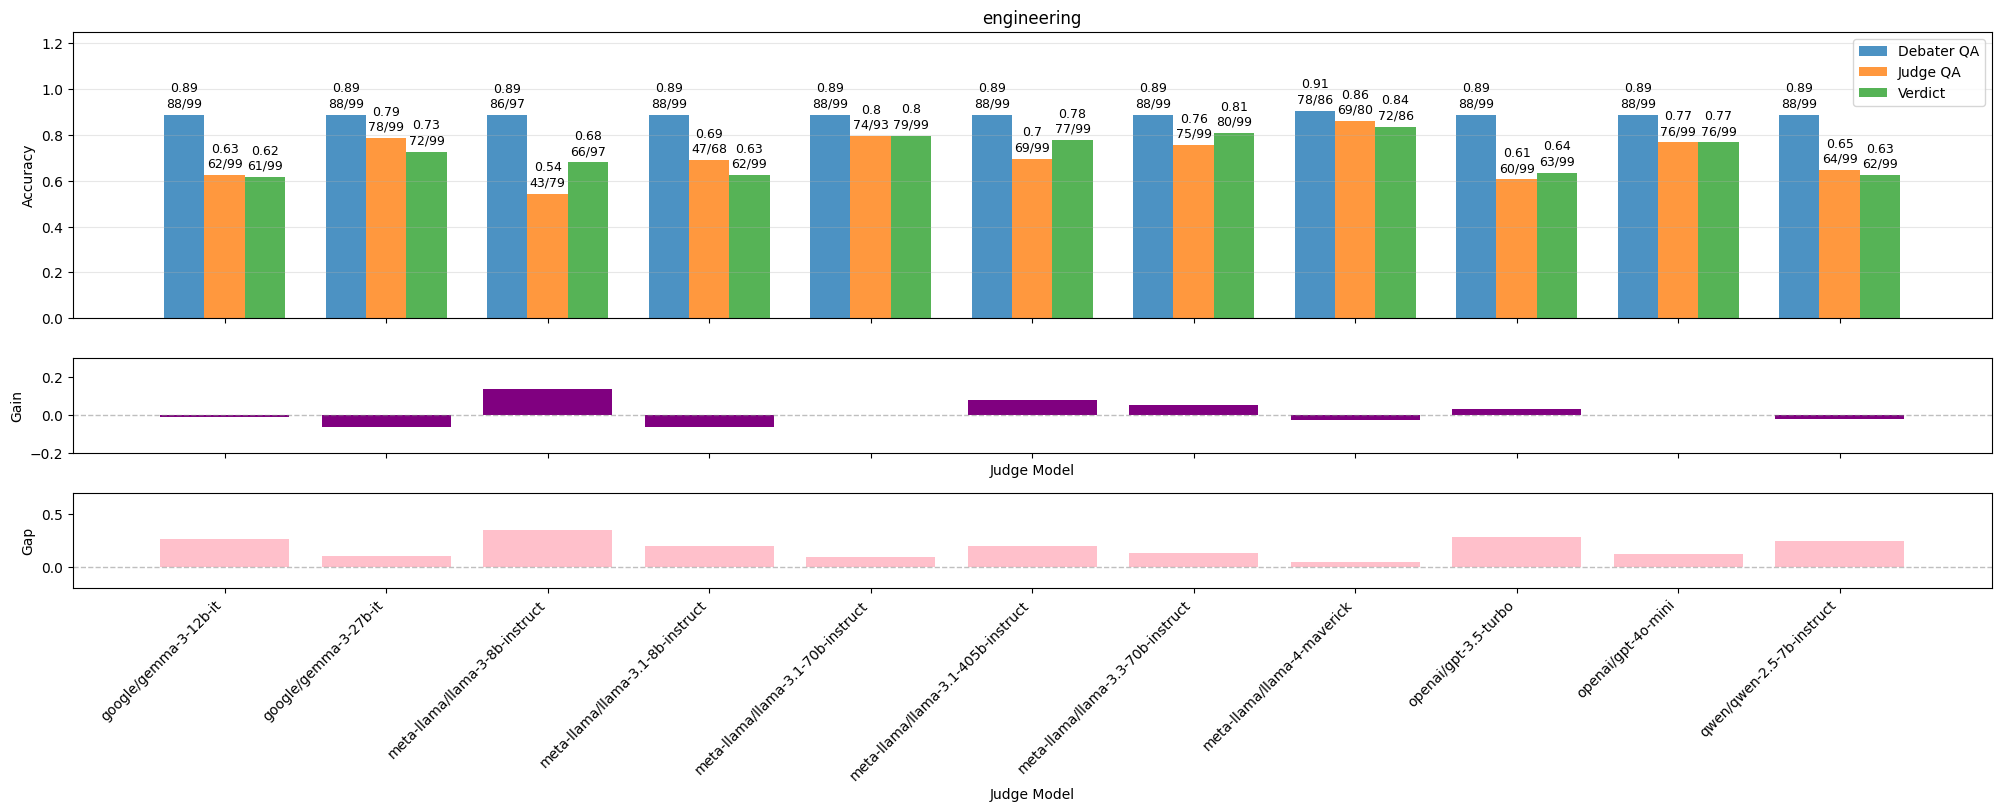

In [239]:
for field in verdicts_df['high_level_domain'].unique():
    field_df = verdicts_df[verdicts_df['high_level_domain'] == field]
    field_acc = aggregate_by_fields(field_df, ['config_judge_model_verdicts'])

    ax_acc, ax_gain, ax_gap = plot_results_by_name(field_acc)
    ax_acc.set_title(f'{field}')

    ax_gain.set_ylim([-.2, .3])
    ax_gap.set_ylim([-.2, .7])
    plt.show()

meta-llama/llama-3.1-8b-instruct


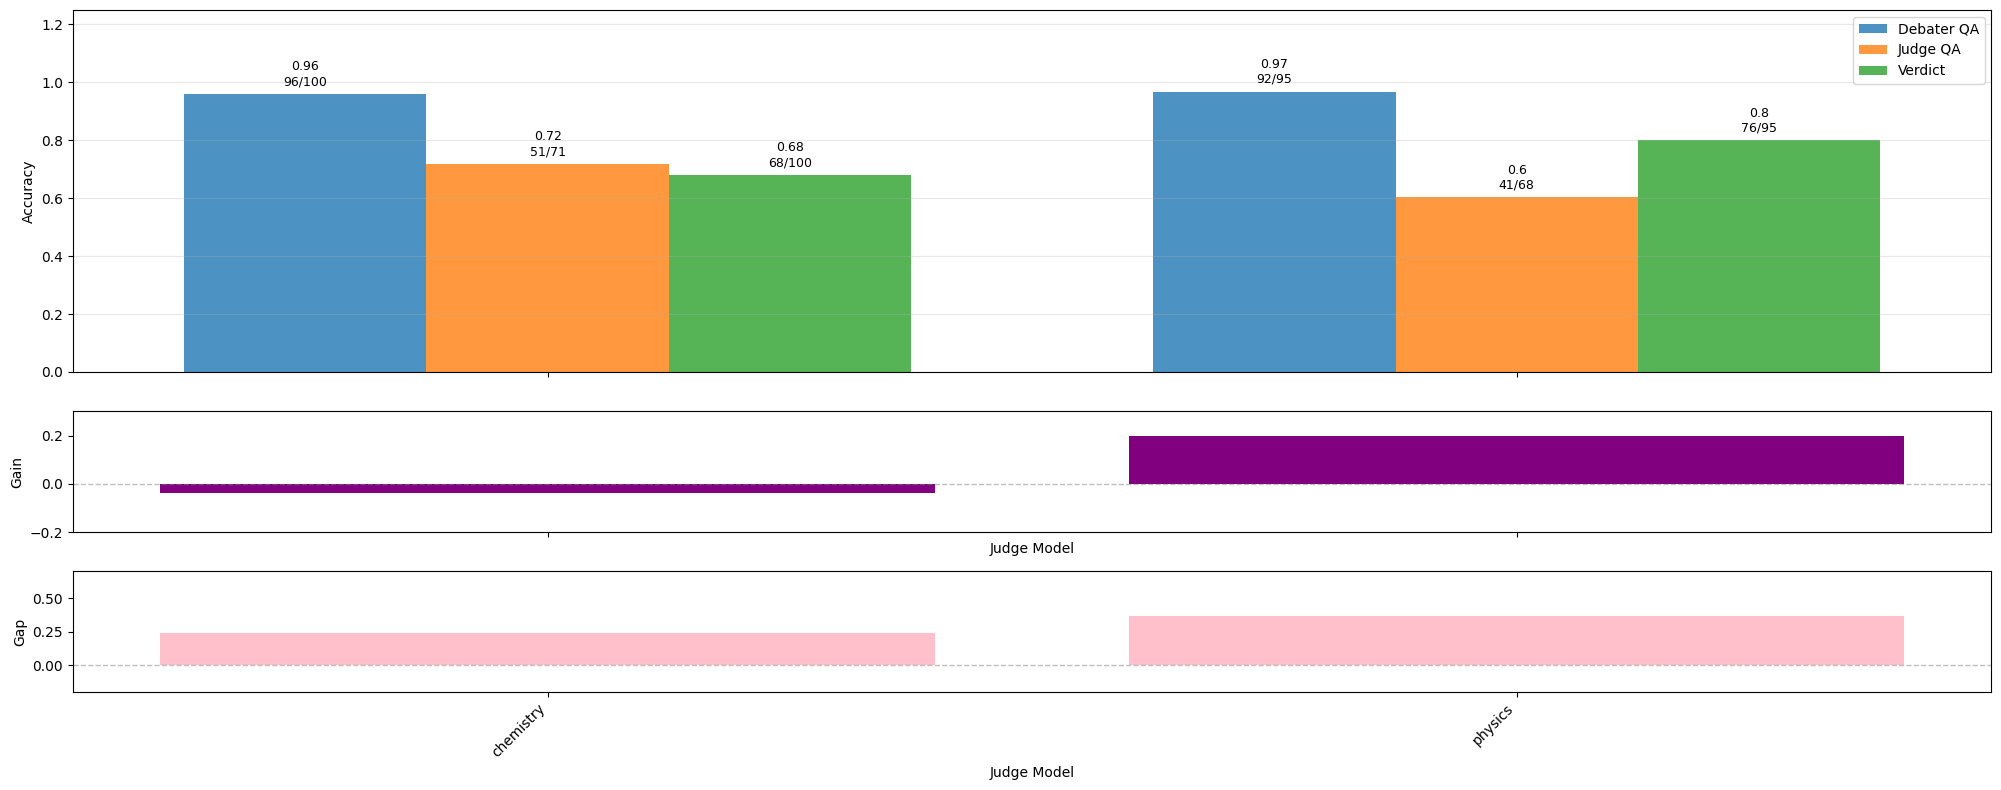

meta-llama/llama-3.1-70b-instruct


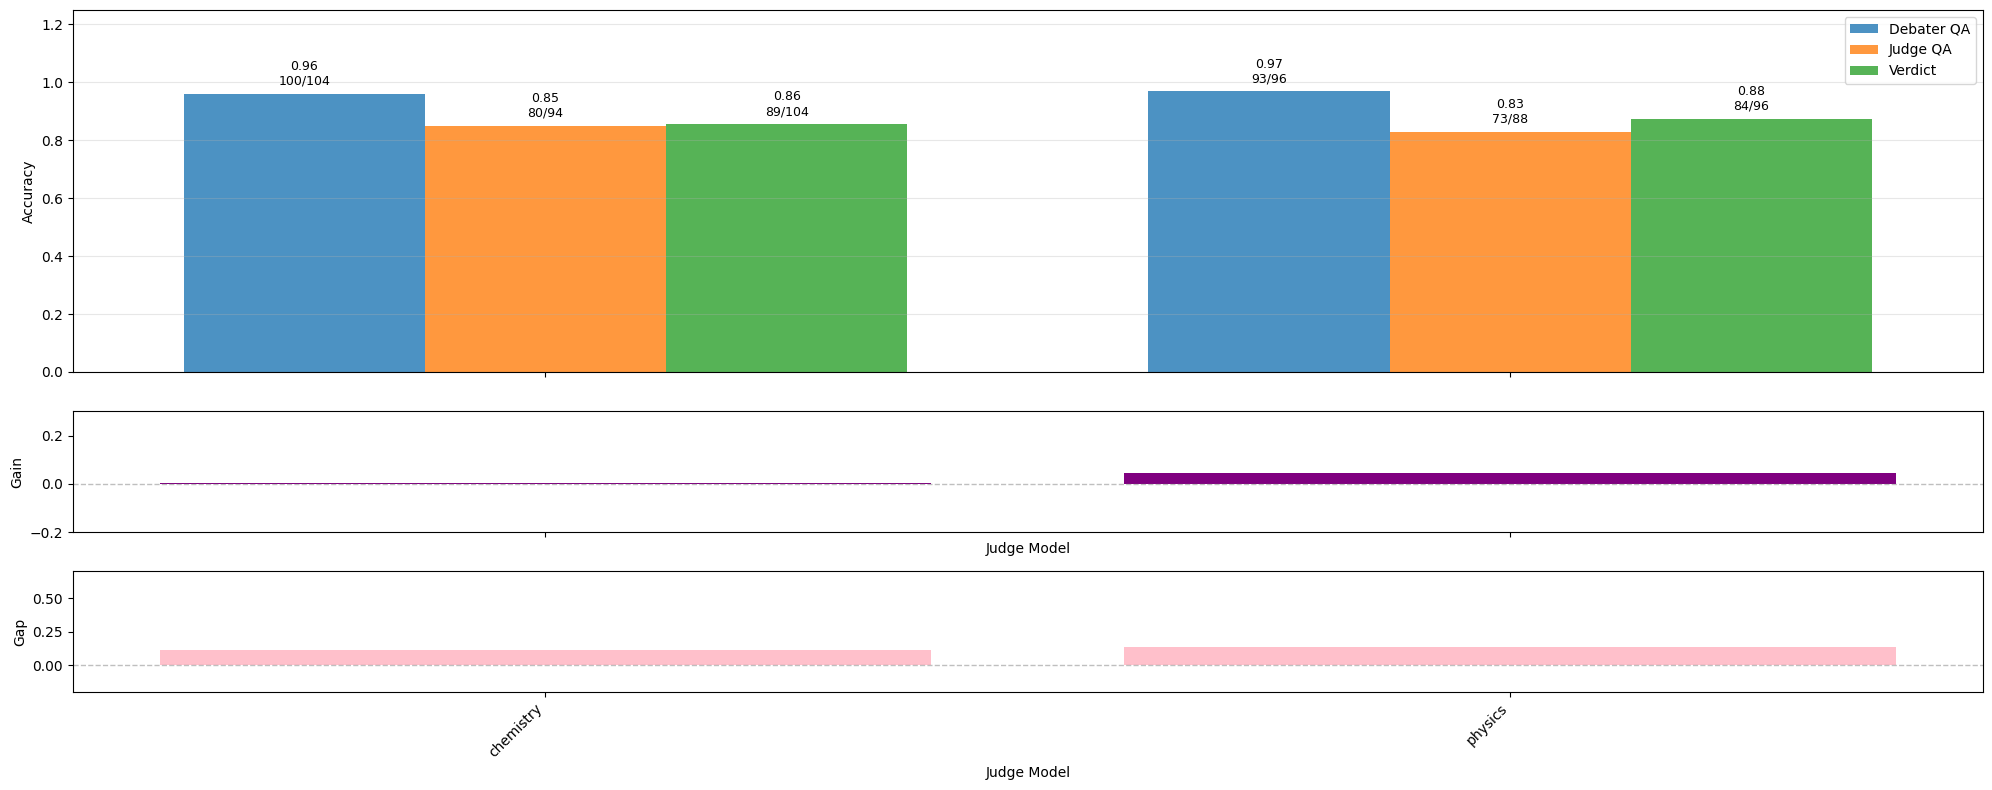

meta-llama/llama-4-maverick


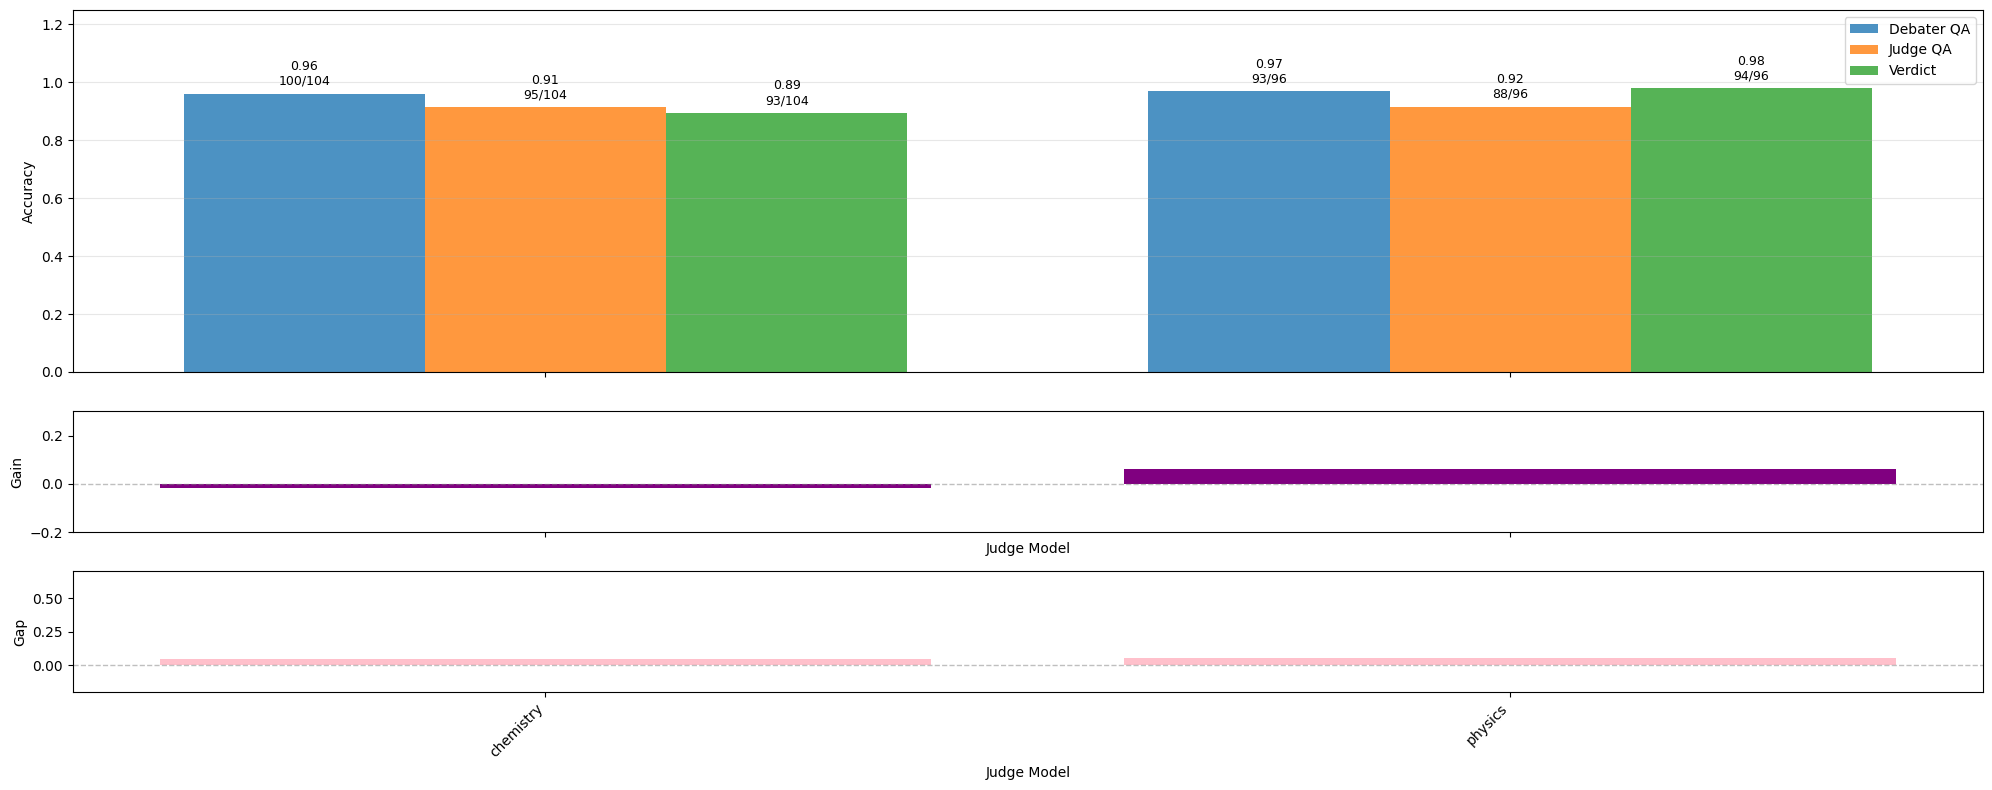

meta-llama/llama-3-8b-instruct


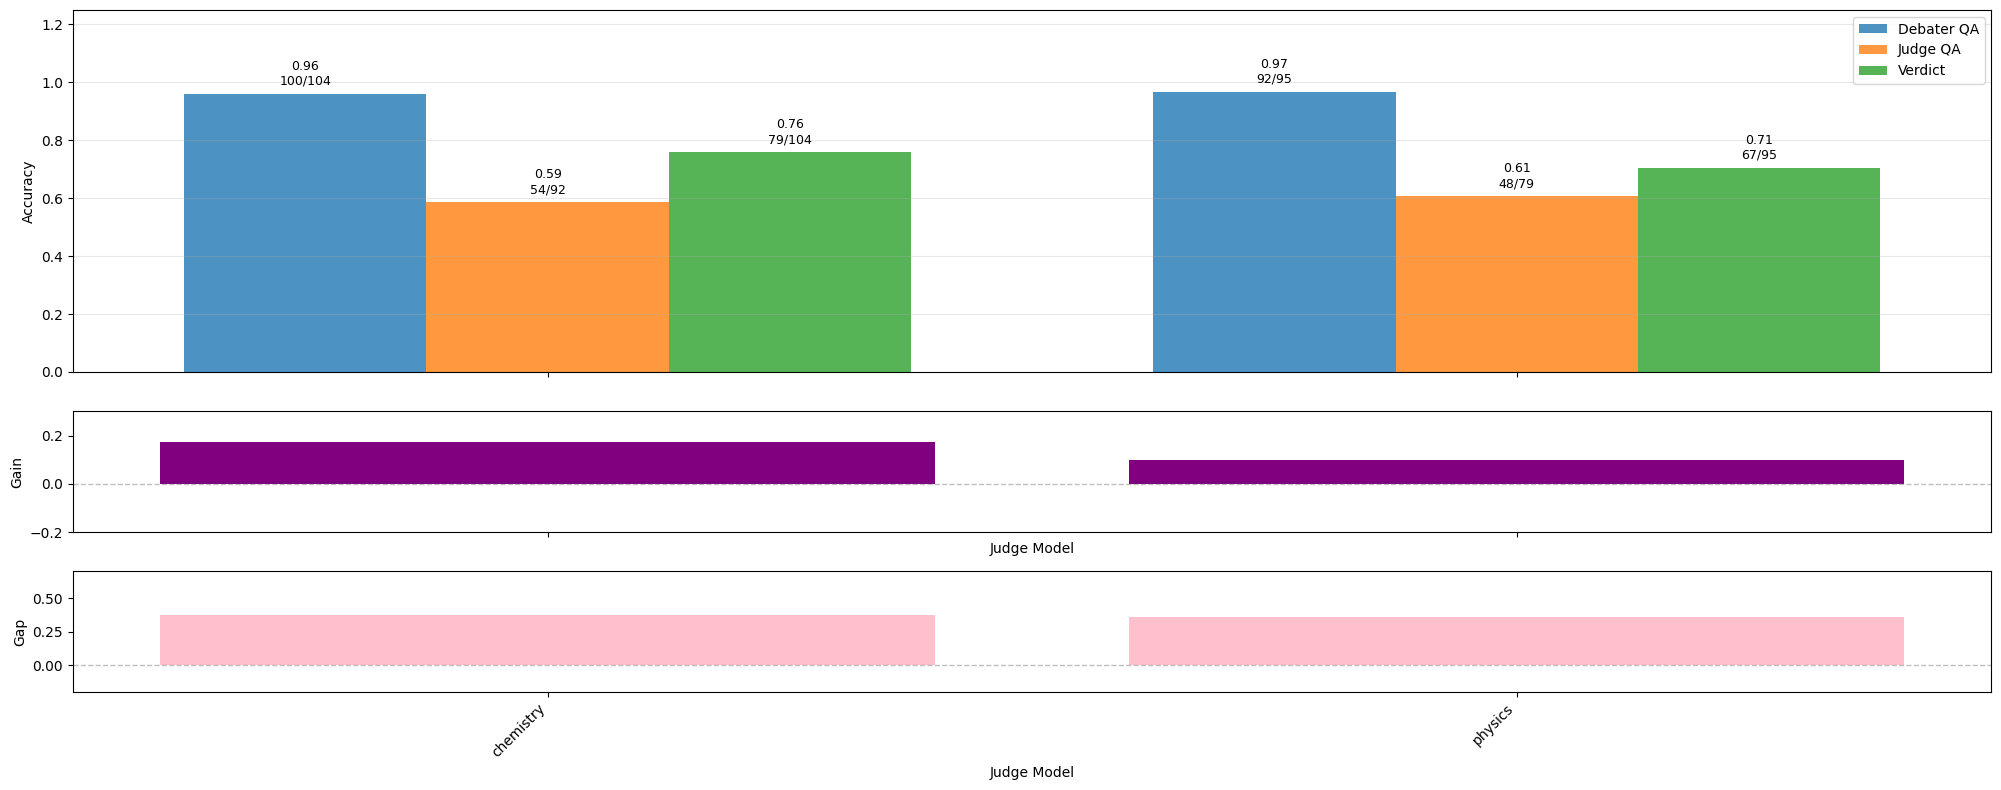

openai/gpt-4o-mini


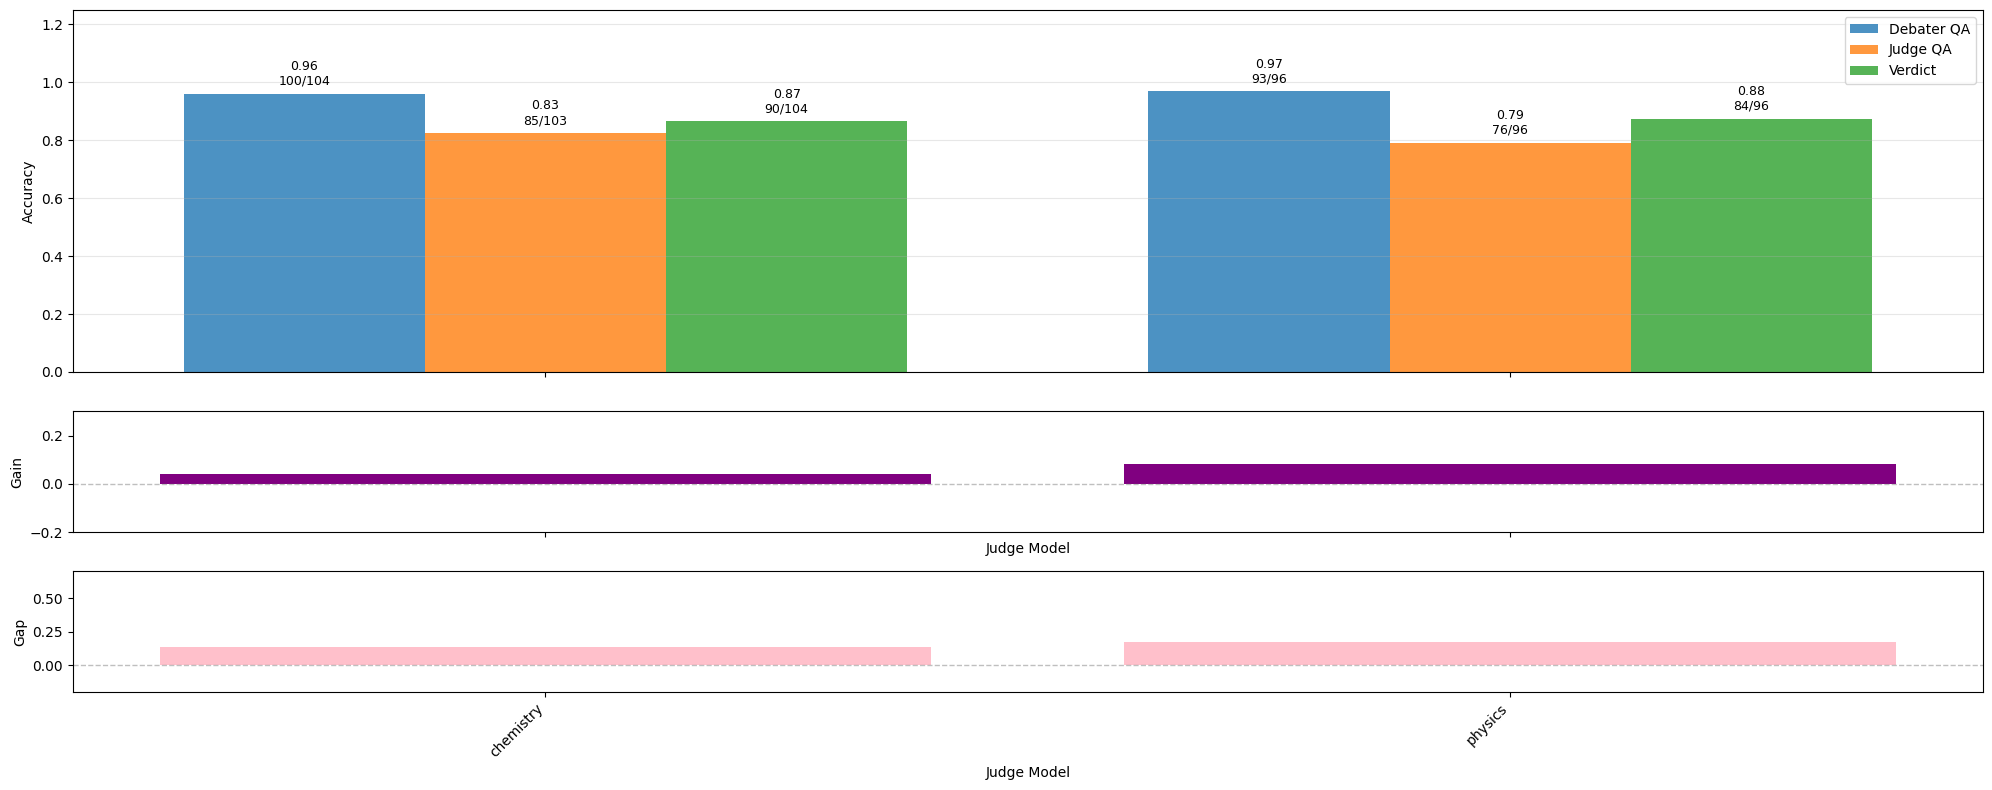

meta-llama/llama-3.3-70b-instruct


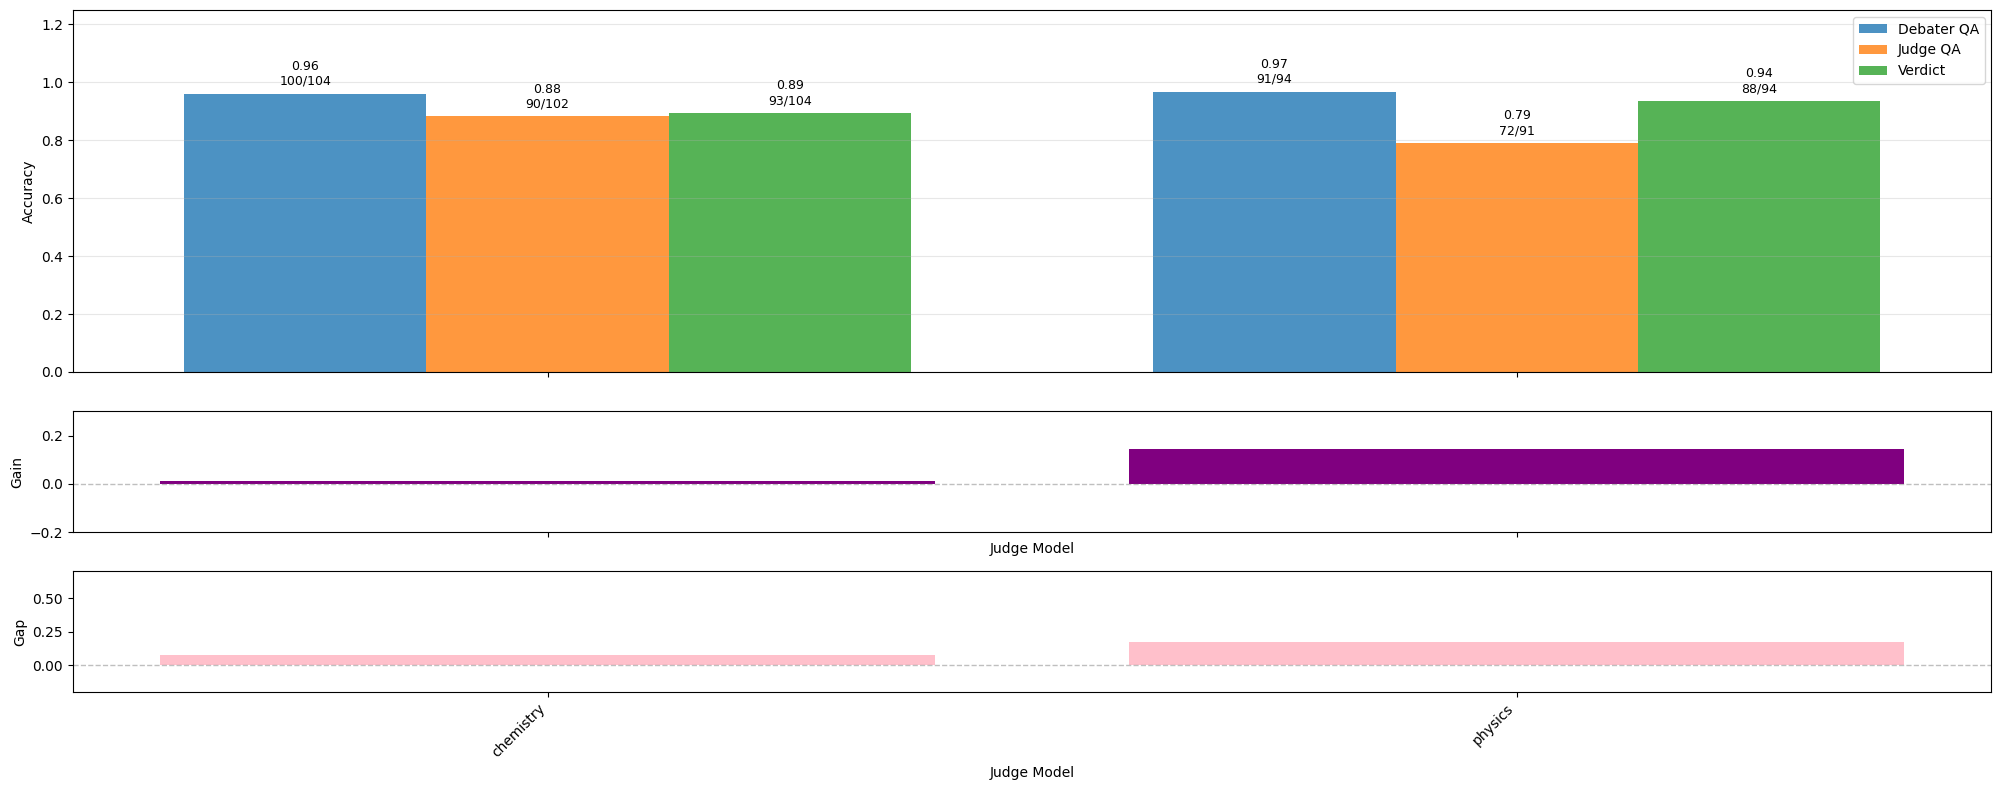

google/gemma-3-27b-it


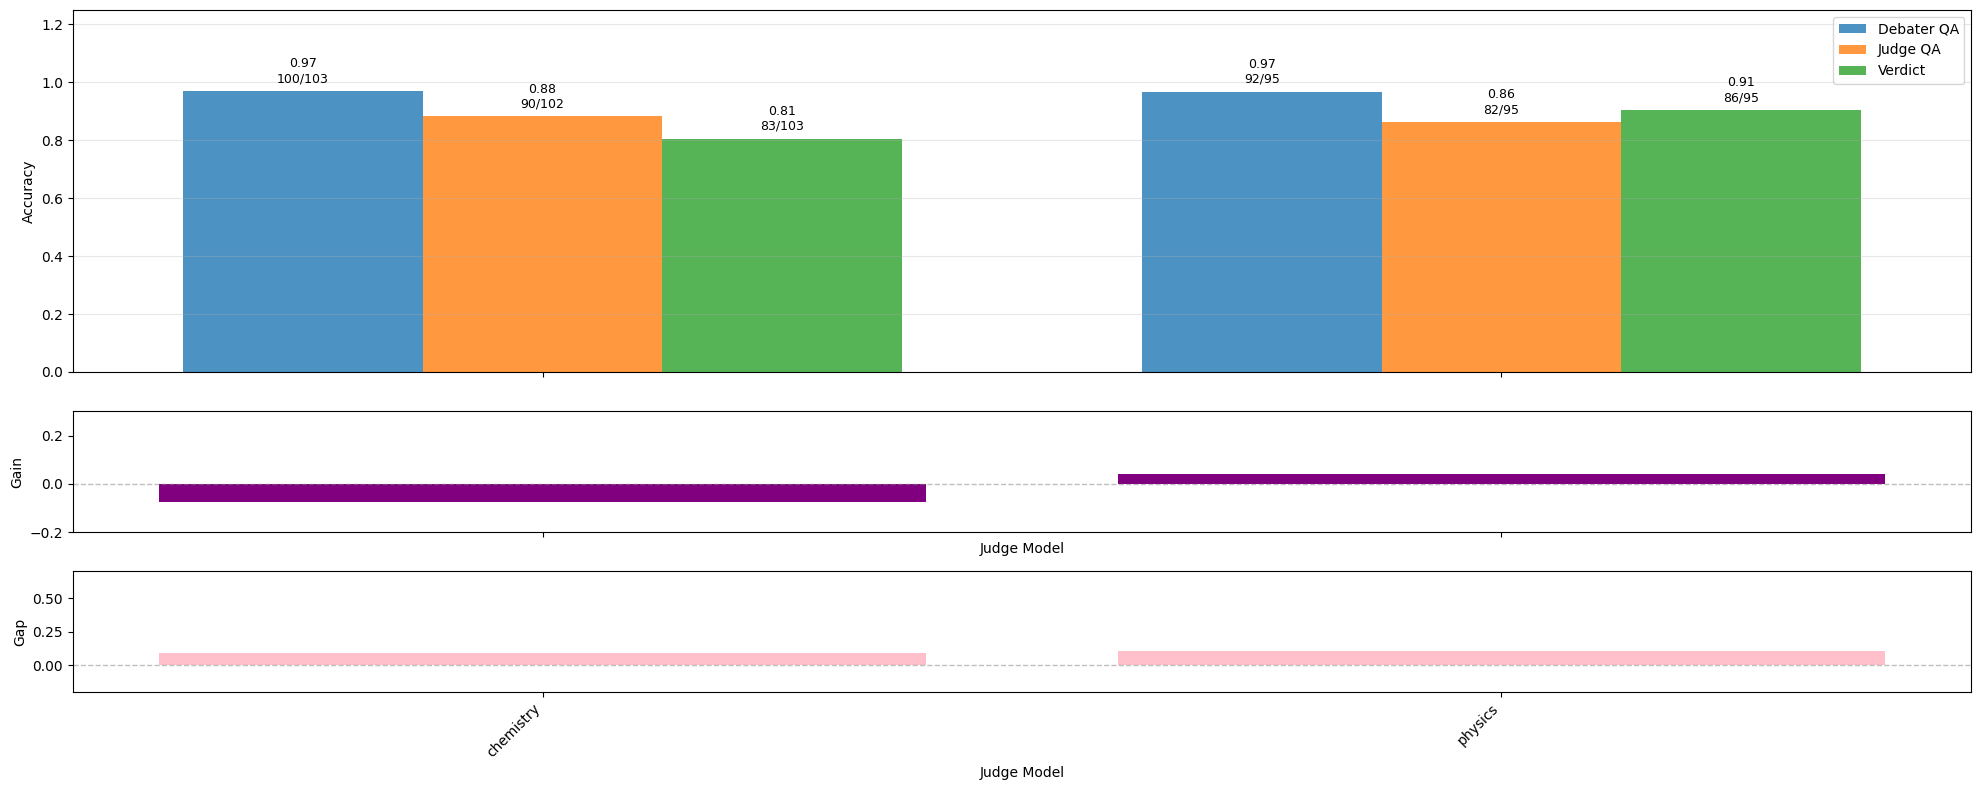

meta-llama/llama-4-scout


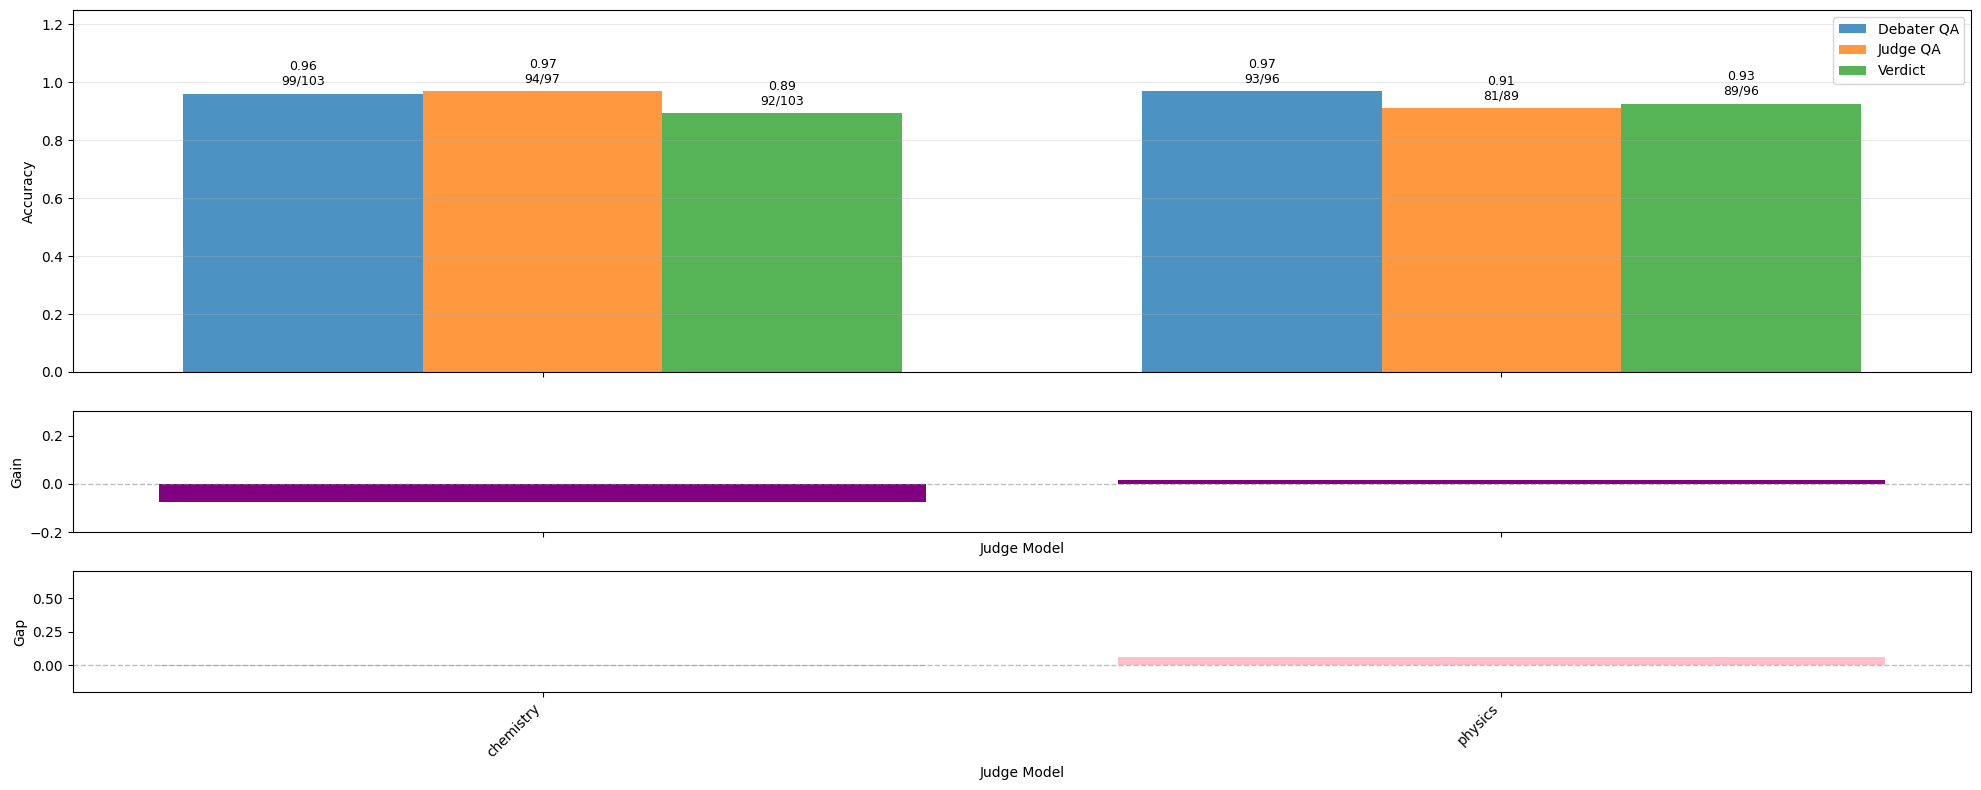

meta-llama/llama-3.1-405b-instruct


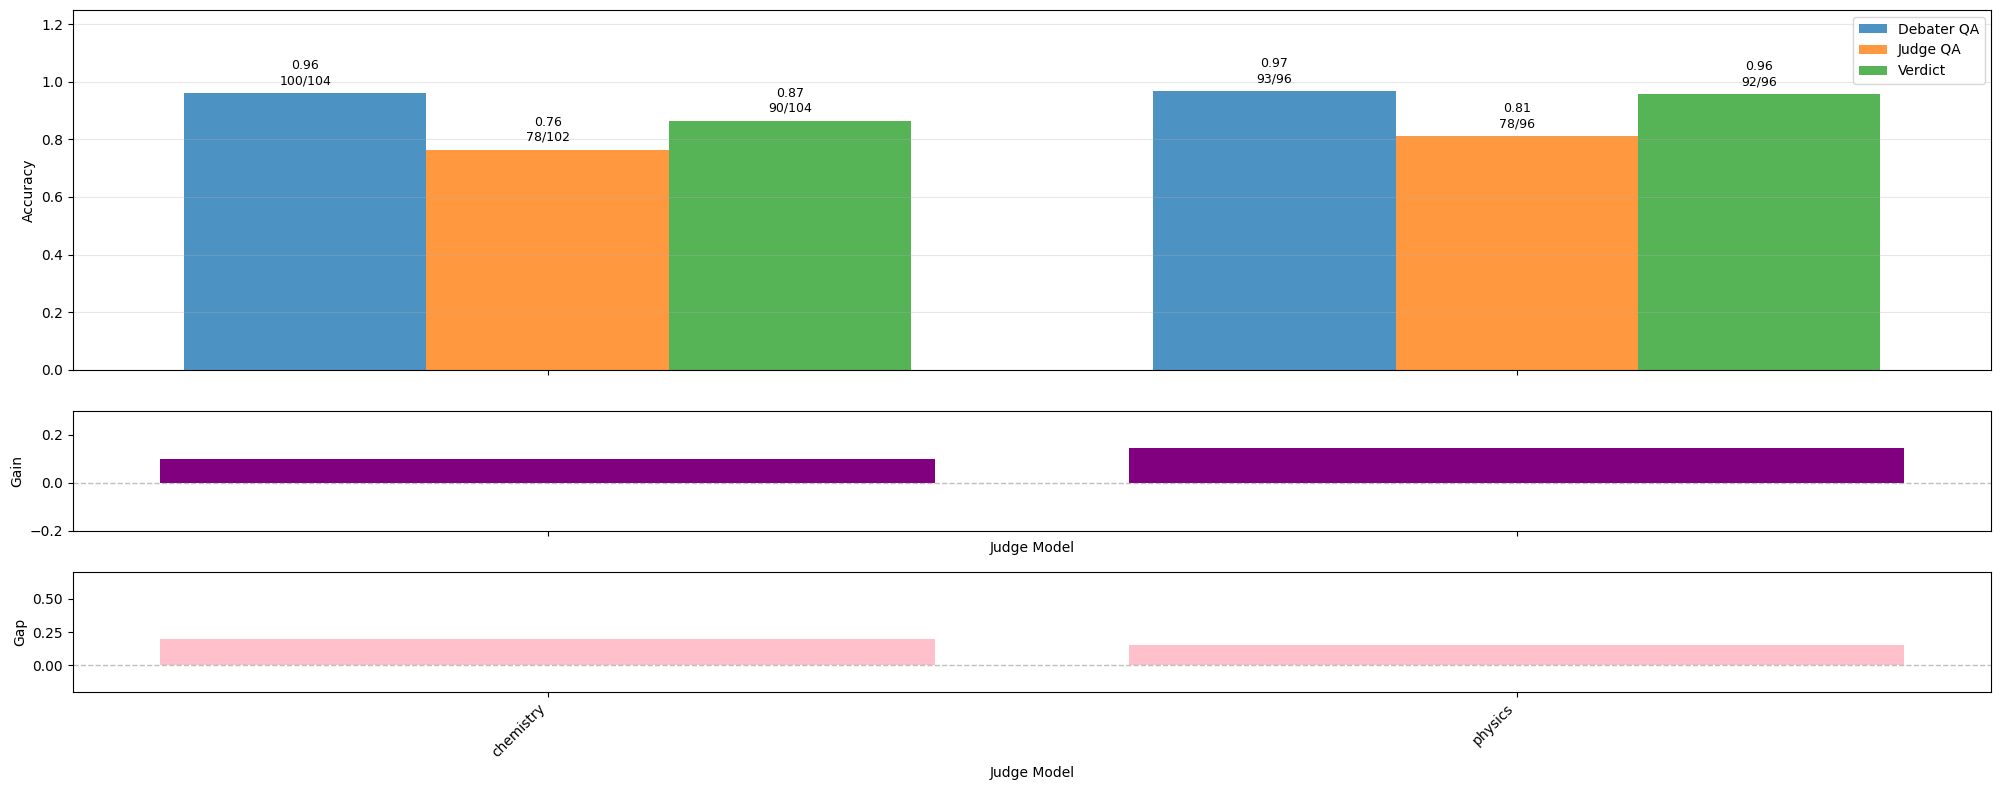

google/gemma-3-12b-it


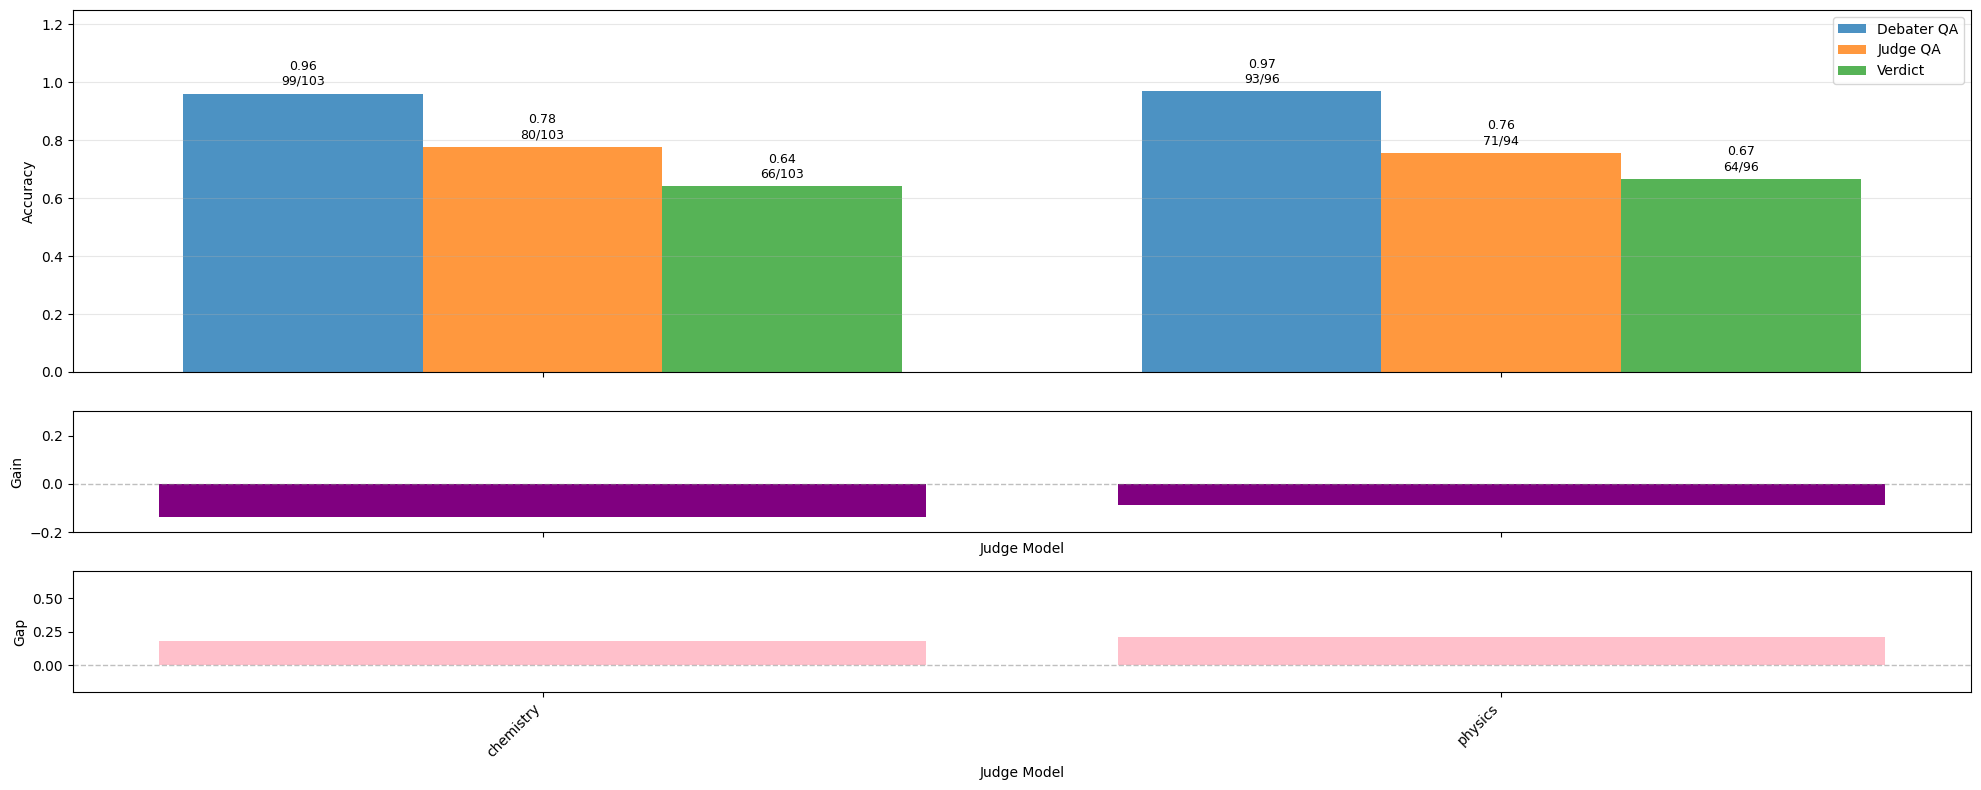

openai/gpt-3.5-turbo


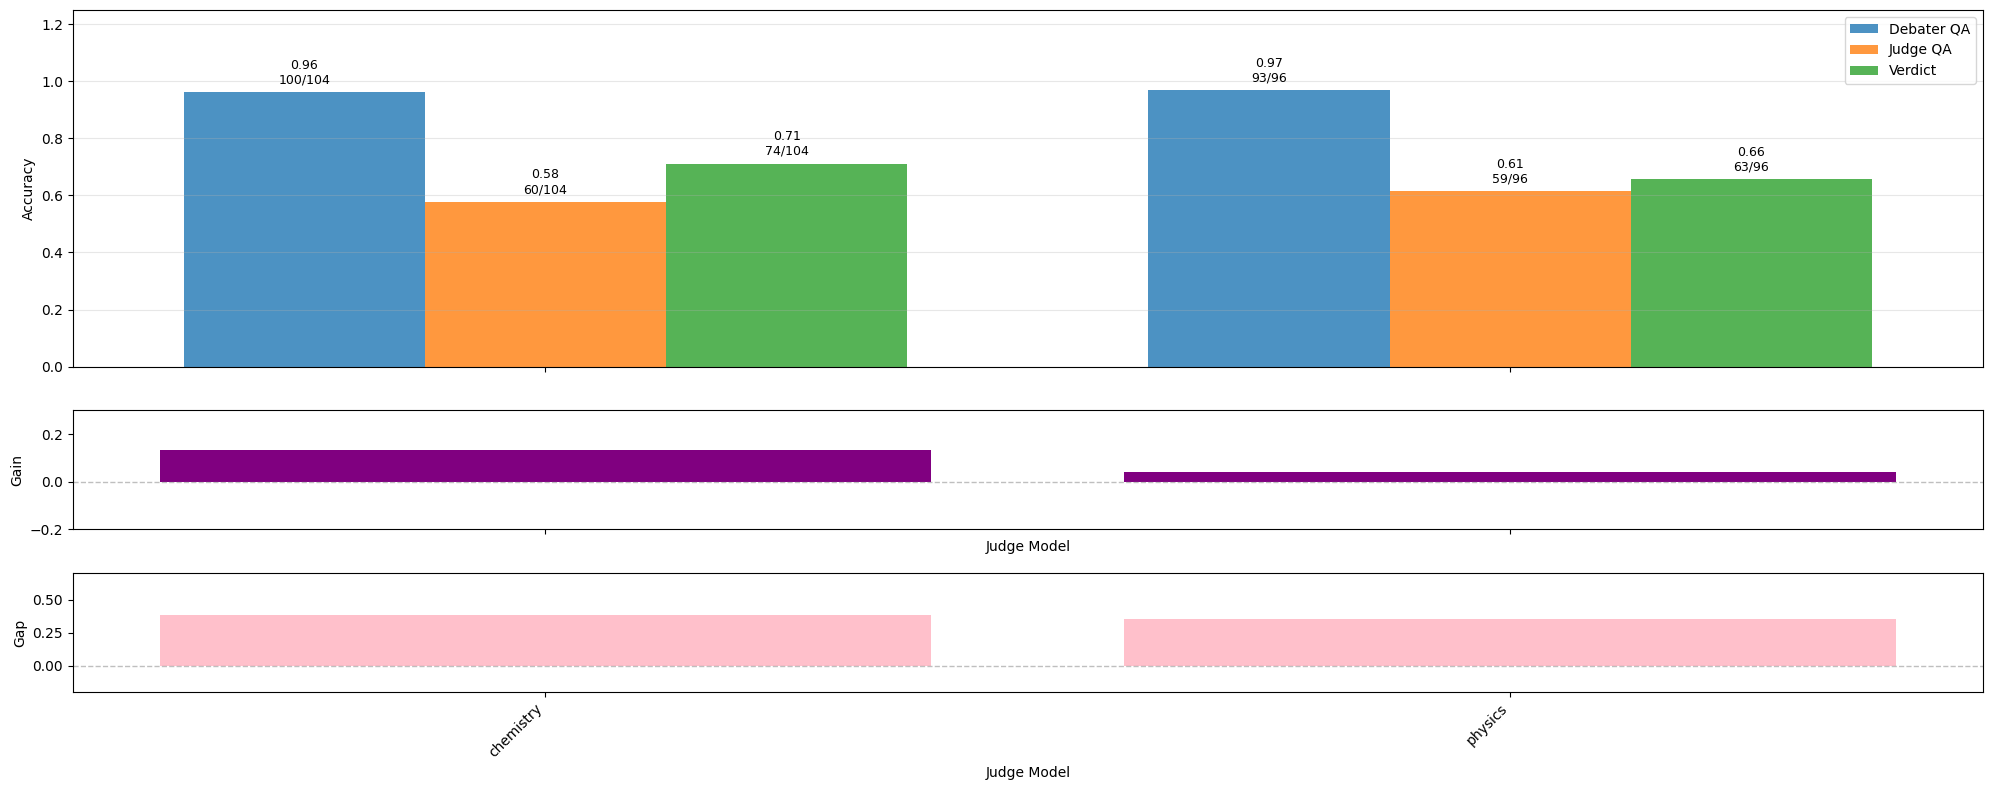

qwen/qwen-2.5-72b-instruct


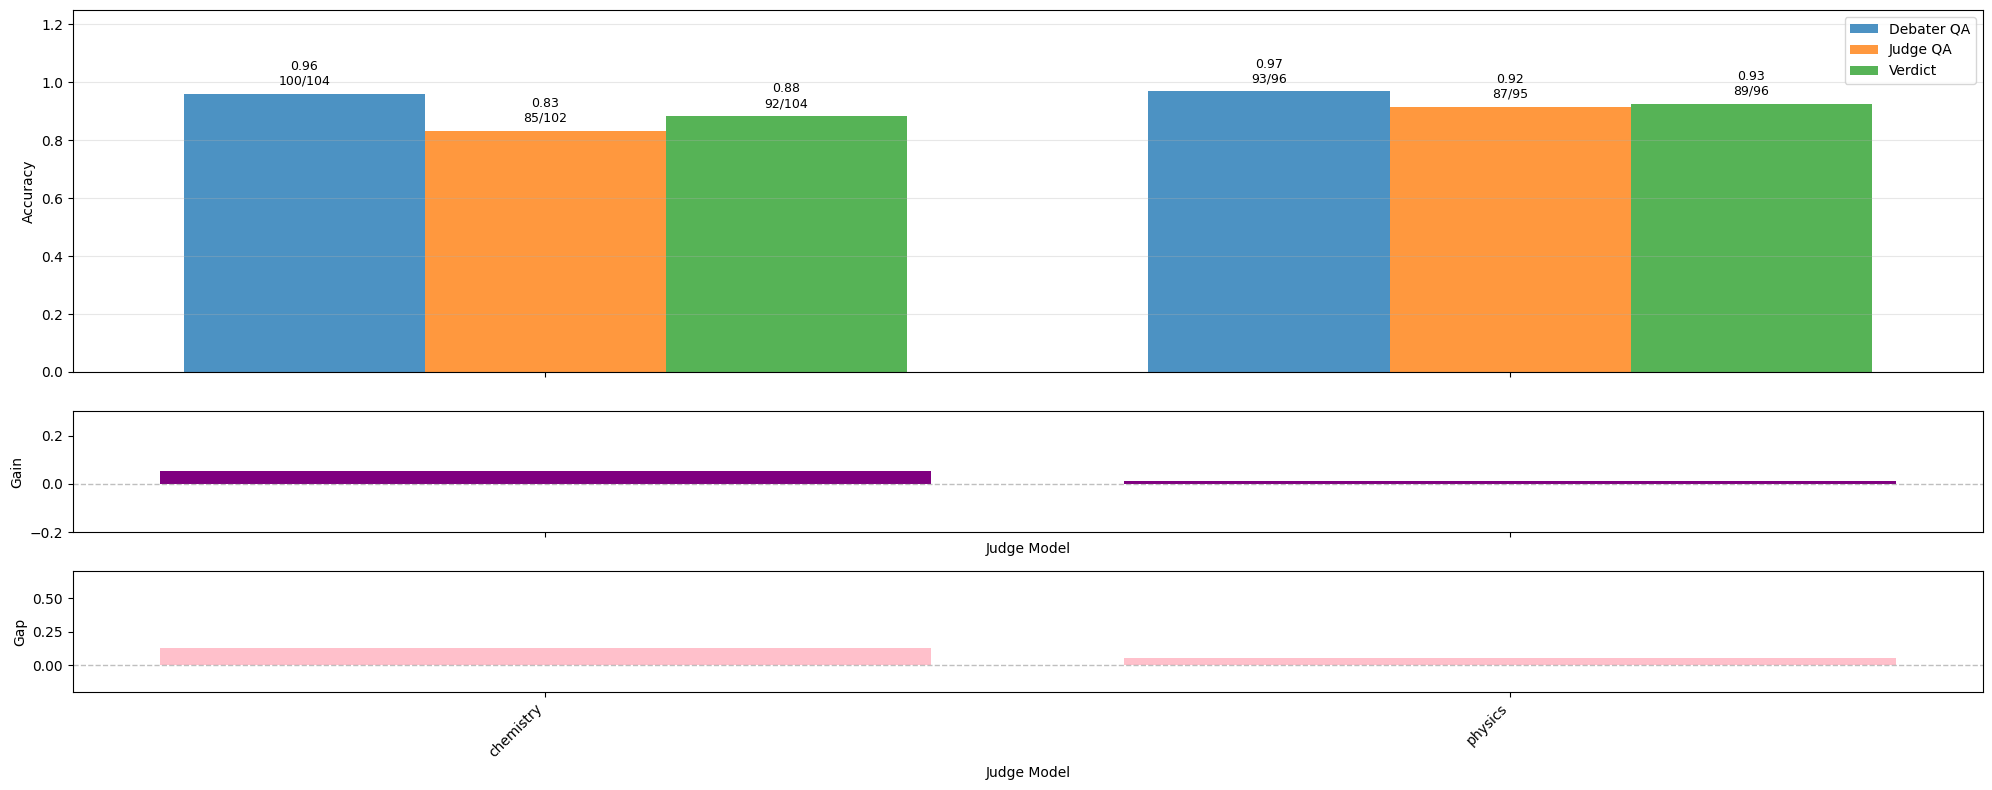

In [224]:
for model_name in verdicts_df['config_judge_model_verdicts'].unique():
    print(model_name)
    model_df = verdicts_df[verdicts_df['config_judge_model_verdicts'] == model_name]
    model_acc = aggregate_by_fields(model_df, ['high_level_domain'])

    plt, ax_gain, ax_gap = plot_results_by_name(model_acc, field=None)

    ax_gain.set_ylim([-.2, .3])
    ax_gap.set_ylim([-.2, .7])
    plt.show()

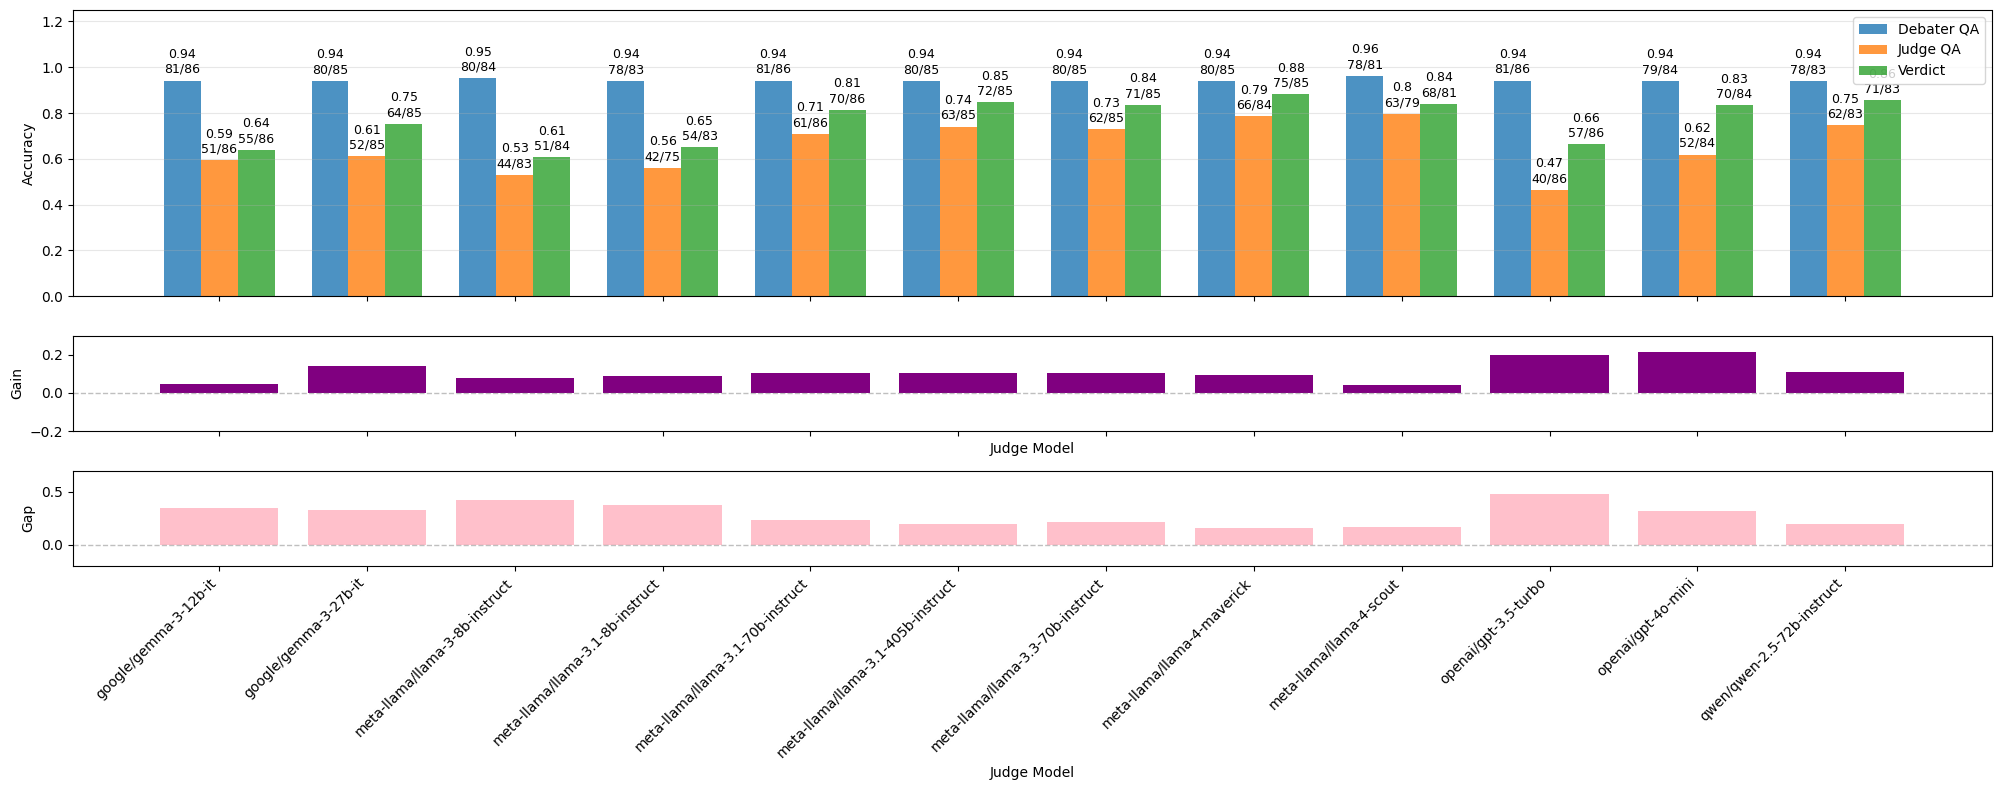

In [190]:
plt, ax_gain, ax_gap = plot_results_by_name(physics_acc)
ax_gain.set_ylim([-.2, .3])
ax_gap.set_ylim([-.2, .7])
plt.show()

In [193]:
physics_acc['gain'].mean(), chemistry_acc['gain'].mean()
# physics_acc['gain'].median(), chemistry_acc['gain'].median()



(np.float64(0.1108999244769499), np.float64(0.09981502260383888))

In [41]:
verdicts_df[verdicts_df['verdict_run_id_verdicts'] == '0aw6bur']['correct_idx_debates'].value_counts(normalize=True)

Series([], Name: proportion, dtype: float64)

In [42]:
verdicts_df[verdicts_df]

ValueError: Boolean array expected for the condition, not object